# Installing

## Packages and adata

In [1]:
# Install
!pip install scanpy scipy umap-learn leidenalg
!pip install infercnvpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.0 MB/s eta 0:00:00


## Import

In [1]:
# Import
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import infercnvpy as cnv
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter("ignore")

sc.settings.set_figure_params(figsize=(5, 5))

sc.logging.print_header()

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pykalman import KalmanFilter
from joblib import Parallel, delayed

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndi
from scipy.stats import ks_2samp

from sklearn.mixture import GaussianMixture

import seaborn as sns

from tqdm.auto import tqdm
from hmmlearn import hmm



In [4]:
# Install benchmarking dataset
adata = sc.read_h5ad("/content/drive/MyDrive/PBMC_simulated_cnas_041025.h5ad")
print(adata)
adata.obs['simulated_cnvs'].value_counts()

AnnData object with n_obs × n_vars = 10309 × 20104
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'cell_type', 'simulated_cnvs'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'chromosome', 'start', 'end', 'strand'
    layers: 'counts'


,count
simulated_cnvs,
,6312
X:106533974-112956833 (CN 4),1731
6:25435484-35035259 (CN 1),895
"22:19807132-29743868 (CN 0), 6:25435484-35035259 (CN 1)",700
22:19807132-29743868 (CN 0),671


In [ ]:
# Full-depth dataset
adata_full = adata.copy()

# Create downsampled datasets at different read depths
adata_75 = adata.copy()
adata_50 = adata.copy()
adata_25 = adata.copy()

# Compute per-cell total counts as a 1D array
cell_totals = np.array(adata.X.sum(axis=1)).flatten()

# Compute median total count
median_count = np.median(cell_totals)

# Downsample each dataset based on this value
sc.pp.downsample_counts(adata_75, total_counts=int(median_count * 0.75))
sc.pp.downsample_counts(adata_50, total_counts=int(median_count * 0.50))
sc.pp.downsample_counts(adata_25, total_counts=int(median_count * 0.25))

In [ ]:
# Compute total counts per cell
counts_original = np.array(adata.X.sum(axis=1)).flatten()
counts_75 = np.array(adata_75.X.sum(axis=1)).flatten()
counts_50 = np.array(adata_50.X.sum(axis=1)).flatten()
counts_25 = np.array(adata_25.X.sum(axis=1)).flatten()

# Organize into a DataFrame
df_counts = pd.DataFrame({
    "Original": counts_original,
    "75% Depth": counts_75,
    "50% Depth": counts_50,
    "25% Depth": counts_25
})

# Convert to long-form for Seaborn
df_long = df_counts.melt(var_name="Dataset", value_name="Total Counts")

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_long, x="Dataset", y="Total Counts")
plt.title("Effect of Downsampling on Read Depth per Cell")
plt.ylabel("Total UMI Counts")
plt.tight_layout()
plt.show()

# Functions for CopyKat

Pipeline functions can also be imported and downloaded from Github repository: https://github.com/biancakolim/inferKat3

In [8]:
# Preprocessing and filtering step

# Limit noise, doublets, and low quality reads for more efficient downstream analysis
def cleanAd(ad, filter_mt=True, set_pct_counts_mt=20, filter_counts=True, set_min_genes=500, set_max_counts=30000, set_min_cells=3):
  ad.var['mt'] = ad.var_names.str.startswith('MT-')
  ribo_prefix = ("RPS","RPL")
  ad.var['ribo'] = ad.var_names.str.startswith(ribo_prefix)
  sc.pp.calculate_qc_metrics(ad, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

  adClean = ad.copy()

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'wspace':0.25}, constrained_layout=True)
  ax1_dict = sc.pl.scatter(adClean, x='total_counts', y='pct_counts_mt', ax=ax1, show=False)
  ax2_dict = sc.pl.scatter(adClean, x='total_counts', y='n_genes_by_counts',ax=ax2, show=False)
  ax3_dict = sc.pl.scatter(adClean, x='pct_counts_ribo', y='n_genes_by_counts',ax=ax3, show=False)
  fig.suptitle('Before filtering')
  plt.show()

  if filter_mt:
    adClean = adClean[adClean.obs['pct_counts_mt']<set_pct_counts_mt,:].copy()
  if filter_counts:
    sc.pp.filter_cells(adClean, min_genes=set_min_genes)
    sc.pp.filter_cells(adClean, max_counts=set_max_counts)
    sc.pp.filter_genes(adClean, min_cells=set_min_cells) # Remove outlier genes

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'wspace':0.25}, constrained_layout=True)
  ax1_dict = sc.pl.scatter(adClean, x='total_counts', y='pct_counts_mt', ax=ax1, show=False)
  ax2_dict = sc.pl.scatter(adClean, x='total_counts', y='n_genes_by_counts',ax=ax2, show=False)
  ax3_dict = sc.pl.scatter(adClean, x='pct_counts_ribo', y='n_genes_by_counts',ax=ax3, show=False)
  fig.suptitle('After filtering')
  plt.show()

  print(adClean.shape)
  return adClean

  # Normalize to correct for cell-to-cell variation
def normalizeAd(ad):
  adNorm = ad.copy()
  adNorm.layers['counts'] = adNorm.X.copy()
  sc.pp.normalize_total(adNorm , target_sum=1e4)
  sc.pp.log1p(adNorm)
  return adNorm

# Detection rate
def filter_dr(adata, low_dr=0.02, high_dr=0.98):
  expression_matrix = adata.layers['counts'].toarray() if 'counts' in adata.layers else adata.X.toarray()
  detection_rate = np.sum(expression_matrix > 0, axis=0) / expression_matrix.shape[0]
  filtered_genes = detection_rate > low_dr
  ad_filtered = adata[:, filtered_genes].copy()
  print(f"{filtered_genes.sum()} genes passed low detection rate filtering")

  # quality check
  num_genes = ad_filtered.shape[1]
  if num_genes < 7000:
      print("WARNING: low data quality; assigned low_dr to high_dr...")
      high_dr = low_dr
      warning = "low data quality"
  else:
      warning = "data quality is ok"
      high_dr = high_dr
  print(warning)

  return ad_filtered, high_dr

In [9]:
# -----------------------------
# Cell Filtering and Annotation Utilities for CNA Inference
# -----------------------------

# Removes known cell cycle genes that may confound CNV signal interpretation
def remove_cell_cycle(adata):
    adata = adata.copy()

    # S-phase genes
    s_genes = [
        'MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1',
        'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1',
        'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76',
        'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51',
        'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM',
        'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8'
    ]

    # G2/M-phase genes
    g2m_genes = [
        'HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A',
        'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF',
        'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB',
        'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP',
        'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5',
        'CDCA3', 'HN1', 'CENPA'
    ]

    # Combine and remove all cell cycle-related genes
    cc_genes = s_genes + g2m_genes
    adata = adata[:, ~adata.var_names.isin(cc_genes)].copy()

    print(f"Shape after removing cell cycle genes: {adata.shape}")
    return adata


# Removes HLA genes which can also introduce noise into CNV analysis
def remove_hla(adata):
    hla_genes = [gene for gene in adata.var_names if gene.startswith('HLA-')]
    print(f"Found {len(hla_genes)} HLA genes to remove.")
    adata = adata[:, ~adata.var_names.isin(hla_genes)].copy()
    return adata


# Applies a second filtering step based on chromosomal gene coverage and transforms the expression matrix
def second_filter(adata, min_genes_per_chr):
    print("Filtering low-quality cells based on chromosomal coverage...")

    genes = adata.var
    expr = adata.layers['counts'].toarray() if 'counts' in adata.layers else adata.X.toarray()

    good_cells = []

    # Filter cells based on number of genes expressed per chromosome
    for i in range(expr.shape[0]):
        cell_expr = expr[i, :]
        nonzero_idx = cell_expr > 0
        cell_chr = genes['chromosome'][nonzero_idx]
        chr_rle = cell_chr.value_counts()

        # Keep cell only if every chromosome has at least min_genes_per_chr expressed genes
        if (chr_rle.min() >= min_genes_per_chr):
            good_cells.append(i)

    adata = adata[good_cells, :].copy()
    print(f"Remaining {adata.n_obs} cells after filtering")

    # Apply variance stabilization using a smoothed log1p(sqrt) transformation
    print("Applying sqrt(x)+sqrt(x+1) transform and mean-centering...")
    expr = adata.layers['counts'].toarray() if 'counts' in adata.layers else adata.X.toarray()
    expr = np.log1p(np.sqrt(expr) + np.sqrt(expr + 1))

    # Mean-center each cell's expression profile
    expr = expr - expr.mean(axis=1, keepdims=True)
    adata.layers['counts'] = expr

    return adata

In [10]:
def smooth_matrix(expr, gaussian_sigma=2, use_kalman=False):
    """
    Apply smoothing to a gene expression matrix using Gaussian filtering
    and optionally a Kalman filter for refinement.

    Parameters:
    ----------
    expr : np.ndarray
        Raw expression matrix with shape (genes × cells).
    gaussian_sigma : float
        Standard deviation for Gaussian kernel used in smoothing.
    use_kalman : bool
        Whether to apply a Kalman filter polish after Gaussian smoothing.

    Returns:
    -------
    np.ndarray
        Smoothed expression matrix with the same shape (genes × cells).
    """

    # Step 1: Transpose matrix for smoothing per cell (i.e., along gene axis)
    expr_T = expr.T  # Now shape is (cells × genes)

    # Step 2: Apply Gaussian filter across genes (columns), not across cells (rows)
    smoothed = gaussian_filter(expr_T, sigma=(0, gaussian_sigma))

    # Step 3: Center each cell (zero mean)
    smoothed -= smoothed.mean(axis=1, keepdims=True)

    # Step 4: Optionally refine smoothing with a Kalman filter
    if use_kalman:
        from pykalman import KalmanFilter  # Imported only if needed

        def kalman_polish(x, dV=0.5, dW=0.01):
            """
            Apply a 1D Kalman filter to a gene expression vector.

            Parameters:
            ----------
            x : np.ndarray
                1D array of gene expression values.
            dV : float
                Observation noise variance.
            dW : float
                Process noise variance.

            Returns:
            -------
            np.ndarray
                Smoothed and mean-centered expression values.
            """
            kf = KalmanFilter(
                transition_matrices=[1],
                observation_matrices=[1],
                initial_state_mean=x[0],
                initial_state_covariance=1,
                observation_covariance=dV,
                transition_covariance=dW
            )
            smoothed_state_means, _ = kf.smooth(x)
            return smoothed_state_means[:, 0] - np.mean(smoothed_state_means[:, 0])

        # Apply Kalman polish in parallel for each cell
        smoothed = Parallel(n_jobs=-1)(
            delayed(kalman_polish)(smoothed[i]) for i in range(smoothed.shape[0])
        )
        smoothed = np.vstack(smoothed)

    # Step 5: Return to original orientation (genes × cells)
    return smoothed.T

In [11]:

def synthetic_baseline(norm_mat, gene_names, cell_names, min_cells=10, max_k=6, seed=123):
    """
    Estimate a synthetic expression baseline using intra-cluster standard deviations.

    Args:
        norm_mat: np.ndarray, smoothed expression matrix (genes × cells)
        gene_names: list of gene names (rows of norm_mat)
        cell_names: list of cell names (columns of norm_mat)
        min_cells: min number of cells per synthetic cluster
        max_k: max number of clusters to try
        seed: reproducibility seed

    Returns:
        expr_relat_df: genes × cells matrix of expression relative to synthetic baseline
        syn_df: genes × clusters matrix of synthetic baselines
        cl_labels: cluster labels for each cell
    """
    np.random.seed(seed)
    norm_df = pd.DataFrame(norm_mat, index=gene_names, columns=cell_names)

    # Hierarchical clustering on transposed expression (cell × gene)
    dist = squareform(pdist(norm_df.T, metric='euclidean'))
    linkage_matrix = linkage(dist, method="ward")

    # Try clustering with max_k clusters, reduce if any have < min_cells
    k = max_k
    cl_labels = cut_tree(linkage_matrix, n_clusters=k).flatten()
    while np.any(np.bincount(cl_labels) < min_cells):
        k -= 1
        if k < 2:
            break
        cl_labels = cut_tree(linkage_matrix, n_clusters=k).flatten()

    expr_relat, syn_cols = [], []
    valid_clusters = np.unique(cl_labels)

    for i in valid_clusters:
        mask = cl_labels == i
        cluster_data = norm_df.iloc[:, mask]

        if cluster_data.shape[1] < min_cells:
            continue

        # Estimate per-gene standard deviation in this cluster
        sd = cluster_data.std(axis=1)

        # Simulate baseline from N(0, σ)
        syn_norm = np.random.normal(loc=0, scale=sd)
        syn_cols.append(pd.Series(syn_norm, index=norm_df.index, name=f"cluster_{i}"))

        # Subtract synthetic baseline from each cell
        expr_cluster = cluster_data.subtract(syn_norm, axis=0)
        expr_relat.append(expr_cluster)

    expr_relat_df = pd.concat(expr_relat, axis=1)
    syn_df = pd.concat(syn_cols, axis=1)

    return expr_relat_df, syn_df, cl_labels

In [ ]:
# Segmentation and predicting CNV calls

def filter_by_length(state_seq, min_len=3):
    """Suppress CNV calls shorter than `min_len` consecutive bins."""
    filtered = state_seq.copy()
    current_state = state_seq[0]
    start = 0
    for i in range(1, len(state_seq)):
        if state_seq[i] != current_state:
            if current_state != "neutral" and (i - start) < min_len:
                filtered[start:i] = ["neutral"] * (i - start)
            current_state = state_seq[i]
            start = i
    # Check the last run
    if current_state != "neutral" and (len(state_seq) - start) < min_len:
        filtered[start:] = ["neutral"] * (len(state_seq) - start)
    return filtered


def run_hmm_cnv_segmentation(
    adata,
    bin_size: int = 100,
    n_states: int = 3,
    use_layer: str = "smoothed",  # Fallback to X_cnv if unavailable
    obsm_key: str = "hmm_cnv_states",
    min_cnv_length: int = 3  # <--- New parameter for CNV filtering
):
    """
    Performs HMM-based CNV segmentation on smoothed gene expression data and
    stores bin-level CNV states and summary region calls in the AnnData object.

    Parameters:
    - adata: AnnData object with gene-level expression and genome annotations.
    - bin_size: Number of genes per genomic bin.
    - n_states: Number of HMM states (typically 3: loss, neutral, gain).
    - use_layer: Use 'smoothed' layer if it exists; fallback to 'X_cnv'.
    - obsm_key: Key under adata.obsm where bin-level CNV state calls will be saved.
    - min_cnv_length: Minimum length (in bins) to call a gain/loss.

    Returns:
    - Modified AnnData object with CNV states in `.obsm[obsm_key]` and summaries in `.obs`.
    """

    # Determine input matrix
    if use_layer in adata.layers:
        X_expr = adata.layers[use_layer]
    elif "X_cnv" in adata.obsm:
        X_expr = adata.obsm["X_cnv"]
    else:
        raise ValueError("No suitable expression data found in layers['smoothed'] or obsm['X_cnv'].")

    # Sort genes by chromosome and position
    var = adata.var.copy()
    var = var.sort_values(["chromosome", "start"])
    adata_sorted = adata[:, var.index].copy()
    valid_indices = [adata_sorted.var_names.get_loc(gene) for gene in var.index]
    X_expr = X_expr[:, valid_indices]

    # Binning
    bins = [
        (i, i + bin_size)
        for i in range(0, adata_sorted.n_vars, bin_size)
    ]

    bin_expr, bin_coords = [], []
    for start, end in bins:
        end = min(end, adata_sorted.n_vars)  # prevent overflow
        bin_vals = X_expr[:, start:end].mean(axis=1)
        coords = var.iloc[start:end]
        region = f"{coords['chromosome'].values[0]}:{coords['start'].min()}-{coords['end'].max()}"
        bin_expr.append(bin_vals)
        bin_coords.append(region)

    X_bins = np.vstack(bin_expr).T  # shape: cells × bins

    # HMM segmentation
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    model.fit(X_bins.T.flatten().reshape(-1, 1))  # train on all cells jointly

    # Assign CNV states per cell
    cnv_calls = []
    for i in range(X_bins.shape[0]):
        obs = X_bins[i].reshape(-1, 1)
        state_seq = model.predict(obs)

        # Map numeric states to labels based on sorted means
        state_means = model.means_.flatten()
        sorted_states = np.argsort(state_means)
        state_map = {sorted_states[0]: "loss", sorted_states[1]: "neutral", sorted_states[2]: "gain"}
        labeled_seq = np.vectorize(state_map.get)(state_seq)

        # Apply length filter
        filtered_seq = filter_by_length(labeled_seq, min_len=min_cnv_length)
        cnv_calls.append(filtered_seq)

    # Save bin-level CNV calls
    cnv_df = pd.DataFrame(cnv_calls, columns=bin_coords, index=adata.obs_names)
    adata.obsm[obsm_key] = cnv_df

    # Create cell-level summaries
    def summarize_state(row, target):
        return ", ".join([region for region, call in zip(bin_coords, row) if call == target])

    adata.obs["hmm_gain_regions"] = cnv_df.apply(lambda x: summarize_state(x, "gain"), axis=1)
    adata.obs["hmm_loss_regions"] = cnv_df.apply(lambda x: summarize_state(x, "loss"), axis=1)

    return adata


# InferKat Pipeline

In [15]:
def inferKat(adata, set_min_genes=500, low_dr=0.02, high_dr=0.98, min_genes_per_chr=5, ks_cutoff=0.2):
    """
    Main driver function for copyKat-style CNA inference pipeline.

    Parameters:
    - adata: AnnData object with raw expression matrix
    - set_min_genes: Minimum genes per cell for initial filtering
    - low_dr, high_dr: Dynamic range thresholds for filtering
    - min_genes_per_chr: Minimum gene coverage per chromosome to retain a cell
    - ks_cutoff: KS-statistic cutoff for segmentation (if enabled)

    Returns:
    - ad_filt4: AnnData object with layers storing smoothed and relative expression, and baseline info
    """

    # Step 1: Basic preprocessing
    print("Step 1: read and filter data ...")
    ad_clean = cleanAd(adata, set_min_genes)          # Filter out cells with too few genes

    ad_norm = normalizeAd(ad_clean)                   # Normalize expression
    ad_filt, high_dr = filter_dr(ad_norm, low_dr, high_dr)  # Dynamic range filter

    ad_norm = normalizeAd(ad_clean)                   # Normalize expression
    ad_filt, high_dr = filter_dr(ad_norm, low_dr, high_dr)  # Dynamic range filter

    # Step 2: Annotate genes and filter unwanted genes
    print("Step 2: annotate gene coordinates and secondary filtering genes...")
    cnv.io.genomic_position_from_biomart(ad_filt, biomart_gene_id="hgnc_symbol", species="hsapiens", inplace=True)

    ad_filt2 = remove_cell_cycle(ad_filt)             # Remove cell cycle genes
    ad_filt3 = remove_hla(ad_filt2)                   # Remove HLA genes
    ad_filt4 = second_filter(ad_filt3, min_genes_per_chr)  # Filter low-coverage cells by chromosome

    # Sort genes by genomic position (for segmentation)
    ad_filt4.var = ad_filt4.var.sort_values(by=["chromosome", "start"])
    ad_filt4 = ad_filt4[:, ad_filt4.var.index]

    # Step 3: Smooth expression using Gaussian filter
    print("Step 3: smoothing data with Gaussian filter...")
    expr = ad_filt4.layers['counts'] if 'counts' in ad_filt4.layers else ad_filt4.X.toarray()
    norm_mat_smooth = smooth_matrix(expr)
    ad_filt4.layers["smoothed"] = norm_mat_smooth

    # Step 4: Calculate synthetic baseline and relative expression
    print("Step 4: select and calculate baseline expression...")

    # Transpose to genes × cells
    norm_mat_smooth = ad_filt4.layers["smoothed"].T
    gene_names = ad_filt4.var_names.tolist()
    cell_names = ad_filt4.obs_names.tolist()

    # # Estimate baseline using a synthetic GMM-inspired method
    expr_relat_df, syn_df, cl_labels = synthetic_baseline(norm_mat_smooth, gene_names, cell_names, min_cells=10)

    # Store cluster and relative expression info in AnnData
    ad_filt4.obs["synthetic_cluster"] = pd.Categorical([f"cluster_{i}" for i in cl_labels], ordered=True)
    ad_filt4.layers["relative"] = expr_relat_df.loc[:, ad_filt4.obs_names].values.T  # back to cells × genes
    ad_filt4.uns["synthetic_baseline"] = syn_df  # genes × clusters

    return ad_filt4

Step 1: read and filter data ...


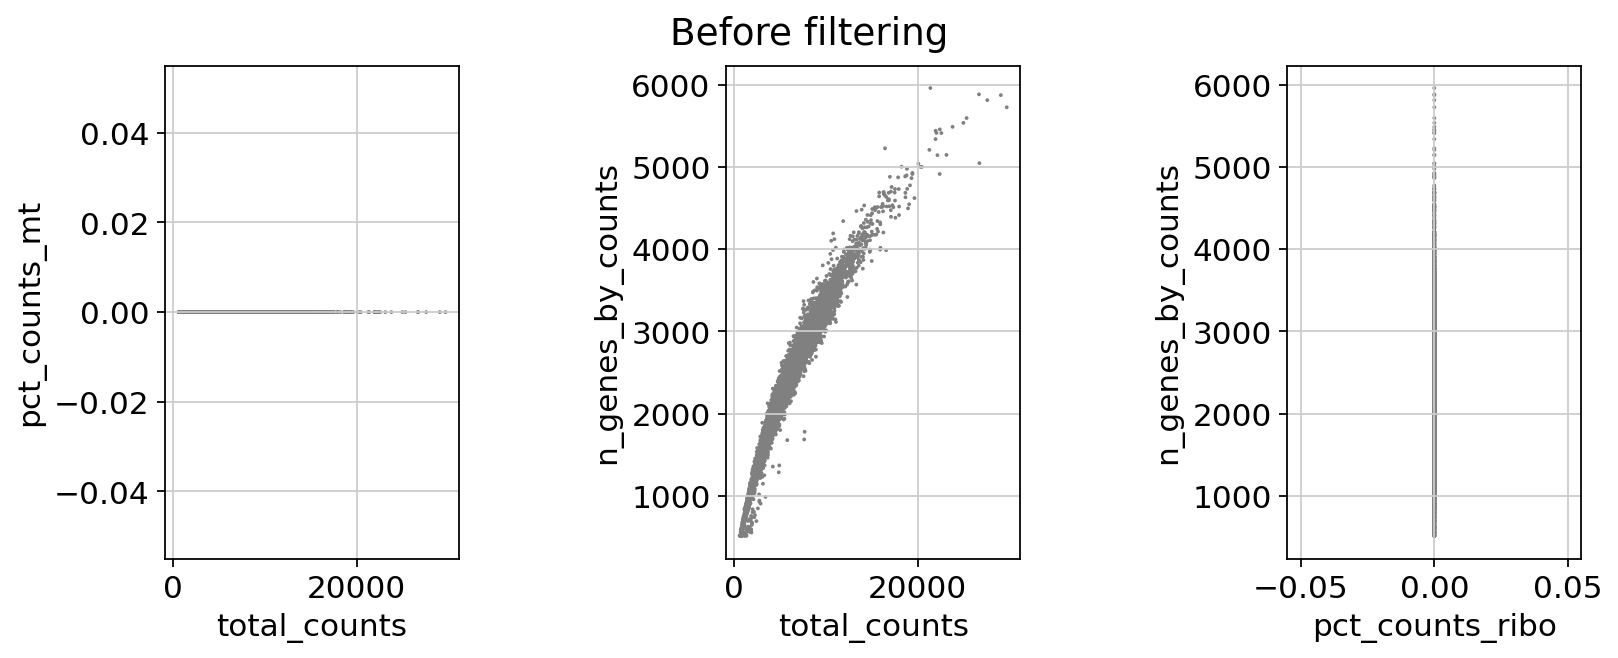

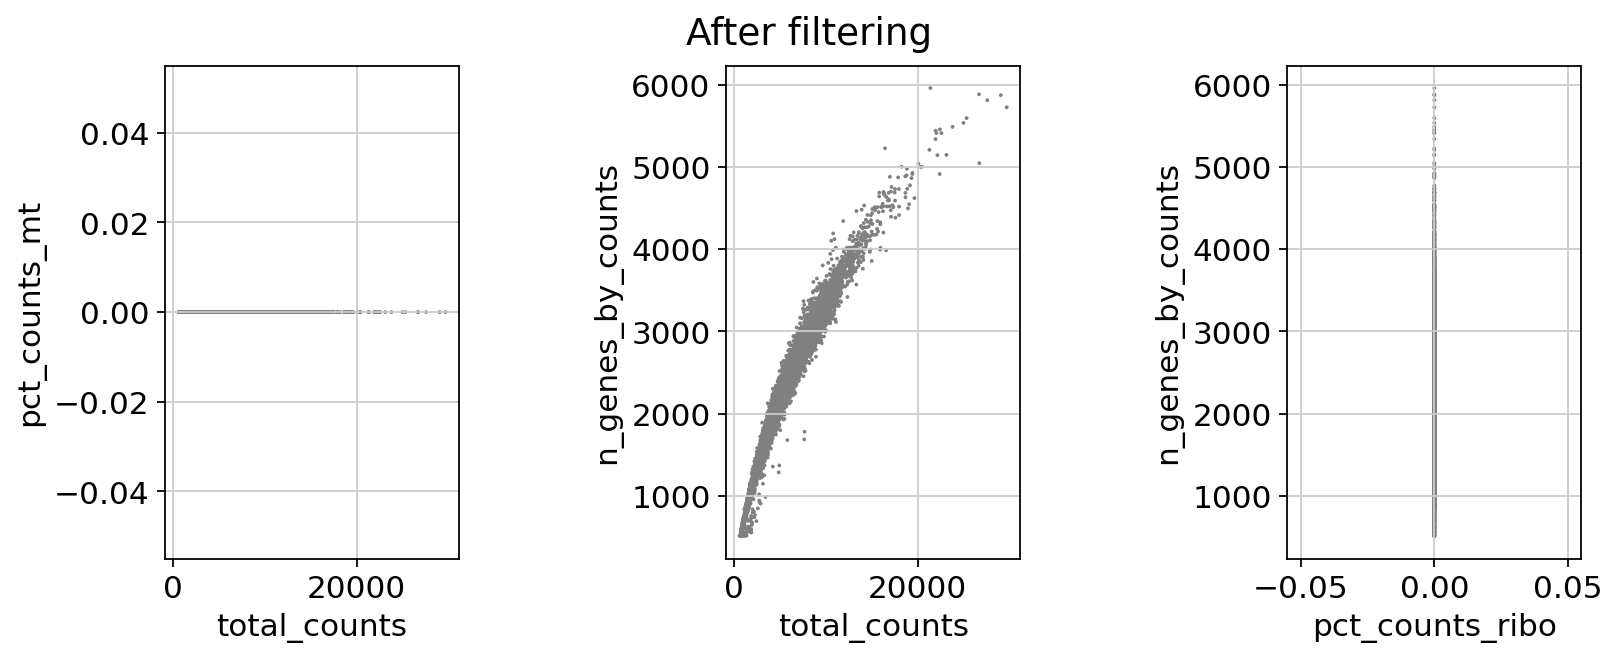

(10309, 19776)
10713 genes passed low detection rate filtering
data quality is ok
10713 genes passed low detection rate filtering
data quality is ok
Step 2: annotate gene coordinates and secondary filtering genes...
Shape after removing cell cycle genes: (10309, 10677)
Found 17 HLA genes to remove.
Filtering low-quality cells based on chromosomal coverage...
Remaining 2235 cells after filtering
Applying sqrt(x)+sqrt(x+1) transform and mean-centering...
Step 3: smoothing data with Gaussian filter...
Step 4: select and calculate baseline expression...


In [16]:
# remove original annotation data from benchmarking to run inferKat
ad_filt_raw = adata.copy()
ad_filt_raw.var.drop(columns=['chromosome', 'strand', 'start', 'end'], inplace=True)
ad_filt_raw.var.head()

ad_filt4 = inferKat(ad_filt_raw, set_min_genes=500, low_dr = 0.02, high_dr = 0.98, min_genes_per_chr = 5, ks_cutoff = 0.2, )

## Continue pipeline to plug into InferCNV here!

Input to infercnv is:
*  the synthetic baseline reference from above inferKat() (can be an average of all clusters or choose 1 cluster)
*  adata object - can be the filtered adata (ad_filt4) that's result of inferKat() OR an adata that's filtered, sorted by chromosome order, but did not undergo second_filter() function. But need to make sure to subset the adata to keep only genes that are in synthetic_baseline so there are the same number of genes

In [ ]:
# Compute the global synthetic baseline by taking the mean expression across all synthetic clusters for each gene
# This baseline is used as a reference to subtract from observed gene expression
ref = ad_filt4.uns["synthetic_baseline"].mean(axis=1).values  # shape: (n_genes,)

# Alternatively, select the baseline from a single synthetic cluster (e.g., 'cluster_2')
# This allows comparison between using the global mean vs. individual clusters as baseline references
ref2 = ad_filt4.uns["synthetic_baseline"]['cluster_2'].values

# Display the reference baseline values from cluster_2
ref2


AttributeError: 'NoneType' object has no attribute 'uns'

In [ ]:
# Display the unique chromosome identifiers present in the gene annotation table (.var)
# This helps verify that gene annotations were correctly mapped to their genomic locations
ad_filt4.var['chromosome'].unique()


array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9',
       'chrX', 'chrY', nan], dtype=object)

  0%|          | 0/1 [00:00<?, ?it/s]

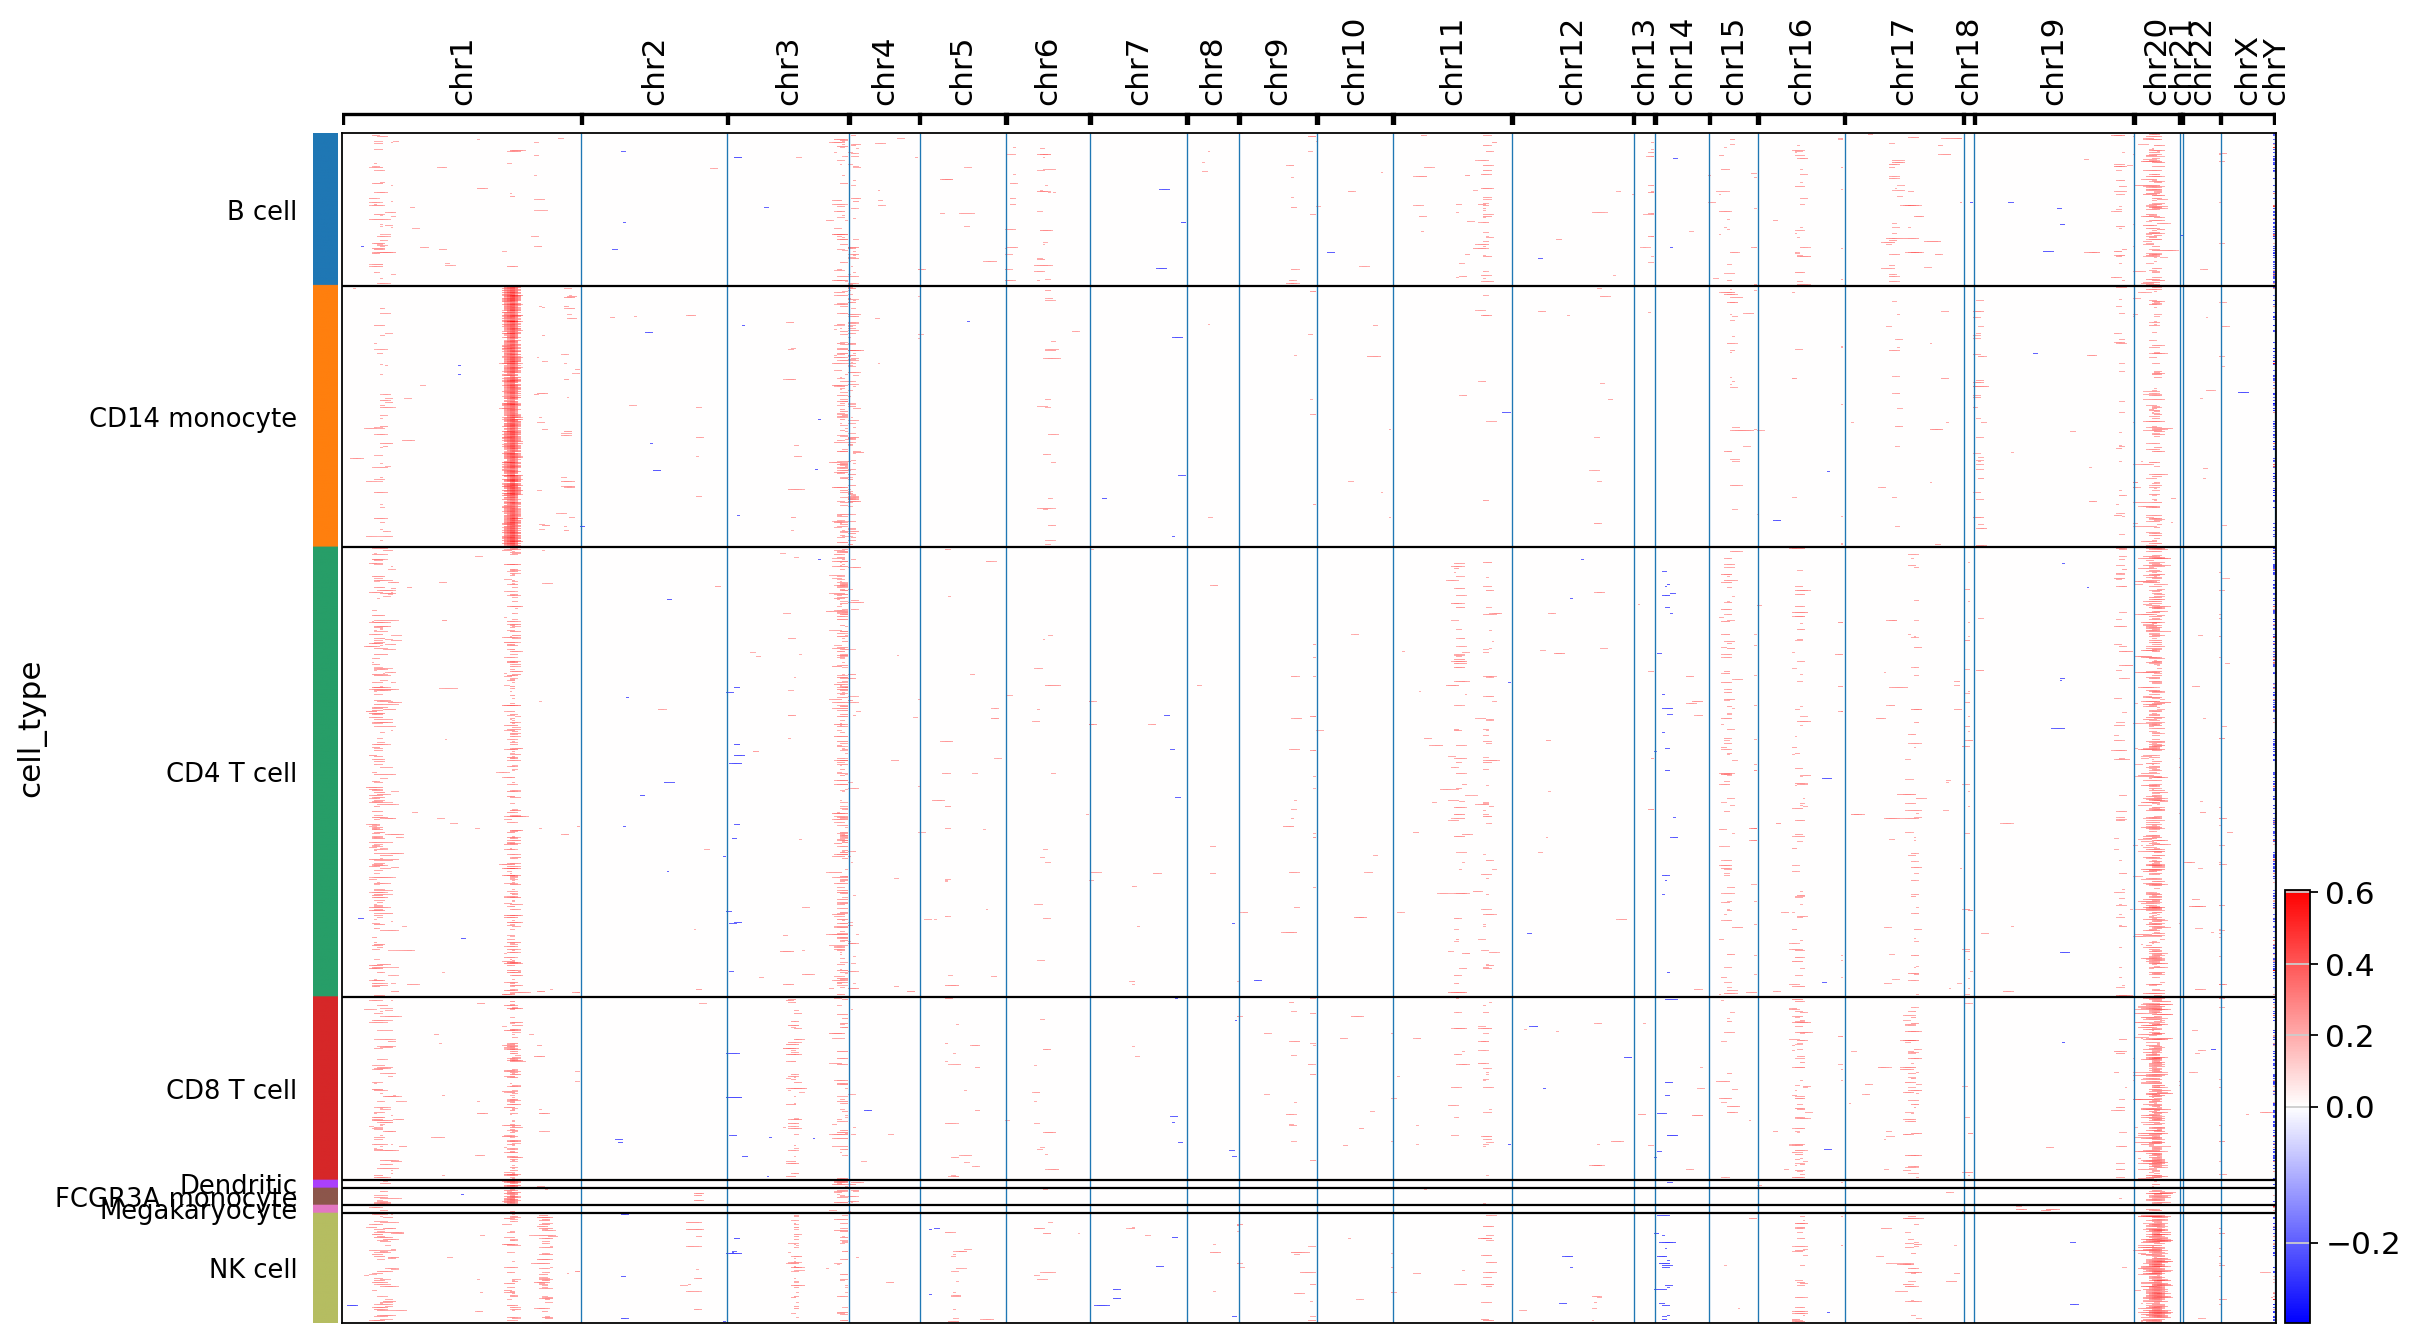

In [ ]:
# Run CNV inference using infercnvpy
# - 'ad_filt4': AnnData object with smoothed and baseline-subtracted expression
# - 'reference': baseline expression vector (e.g., mean or from a specific cluster)
# - 'exclude_chromosomes': excludes any genes mapped to 'nan' chromosome values
# - 'window_size': number of genes per bin for segmentation
# - 'dynamic_threshold': controls sensitivity for calling CNAs
# - 'calculate_gene_values': outputs gene-level CNA scores in .obsm["X_cnv"]
cnv.tl.infercnv(
    ad_filt4,
    reference=ref,
    exclude_chromosomes=['nan'],
    window_size=100,
    dynamic_threshold=2.5,
    calculate_gene_values=True
)

# Visualize inferred CNVs as a heatmap, grouped by cell type
# This helps assess whether certain cell types have stronger or distinct CNA signatures
cnv.pl.chromosome_heatmap(ad_filt4, groupby="cell_type")


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


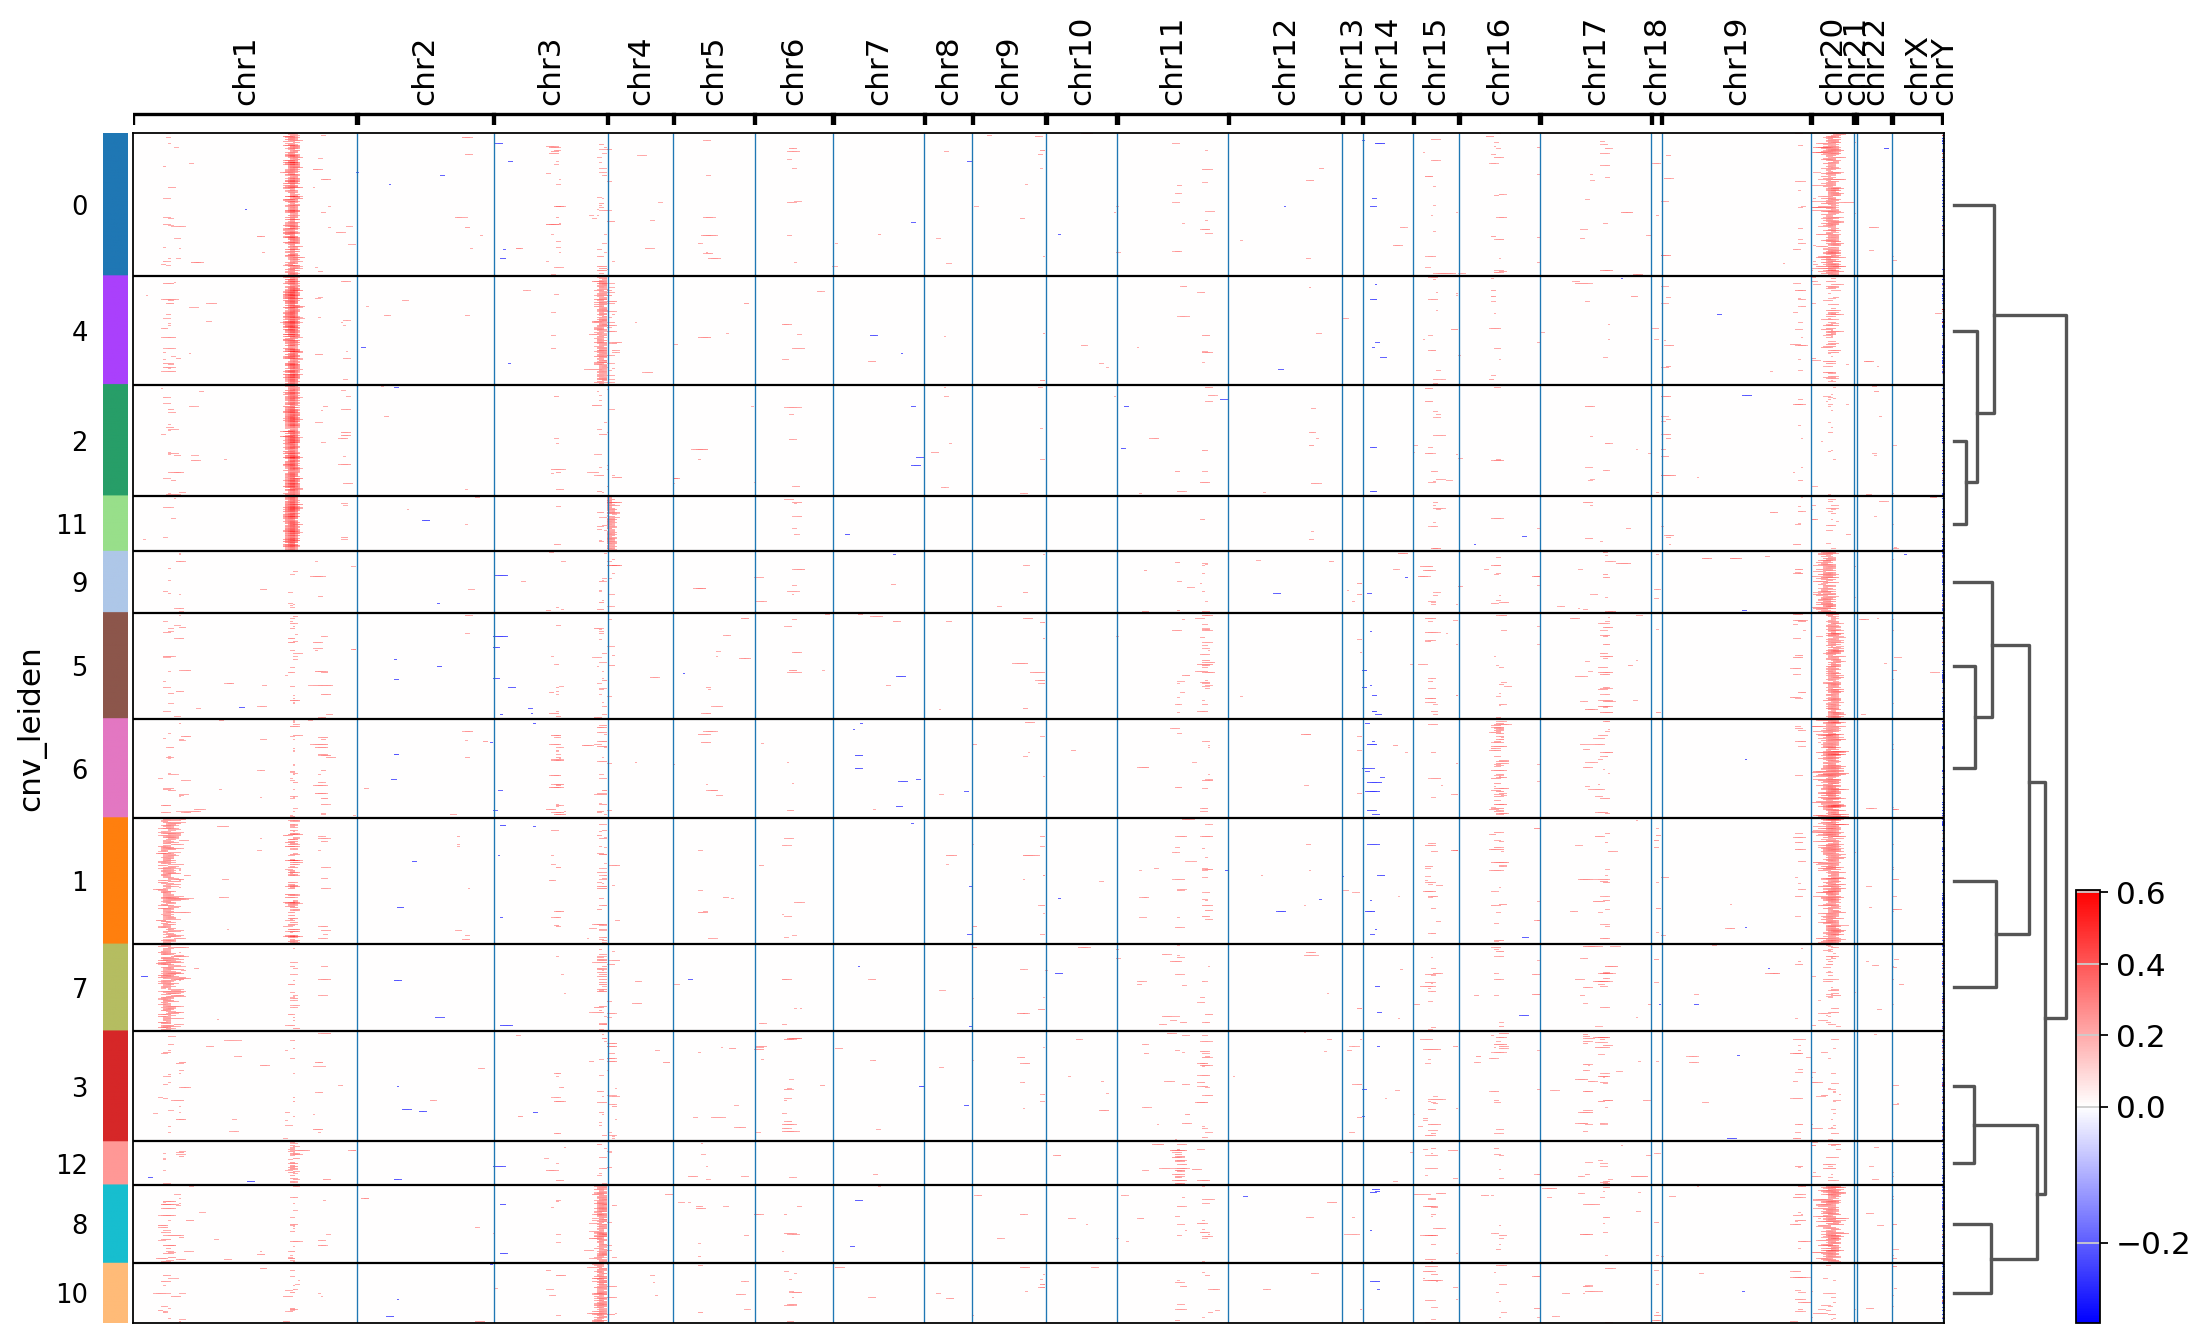

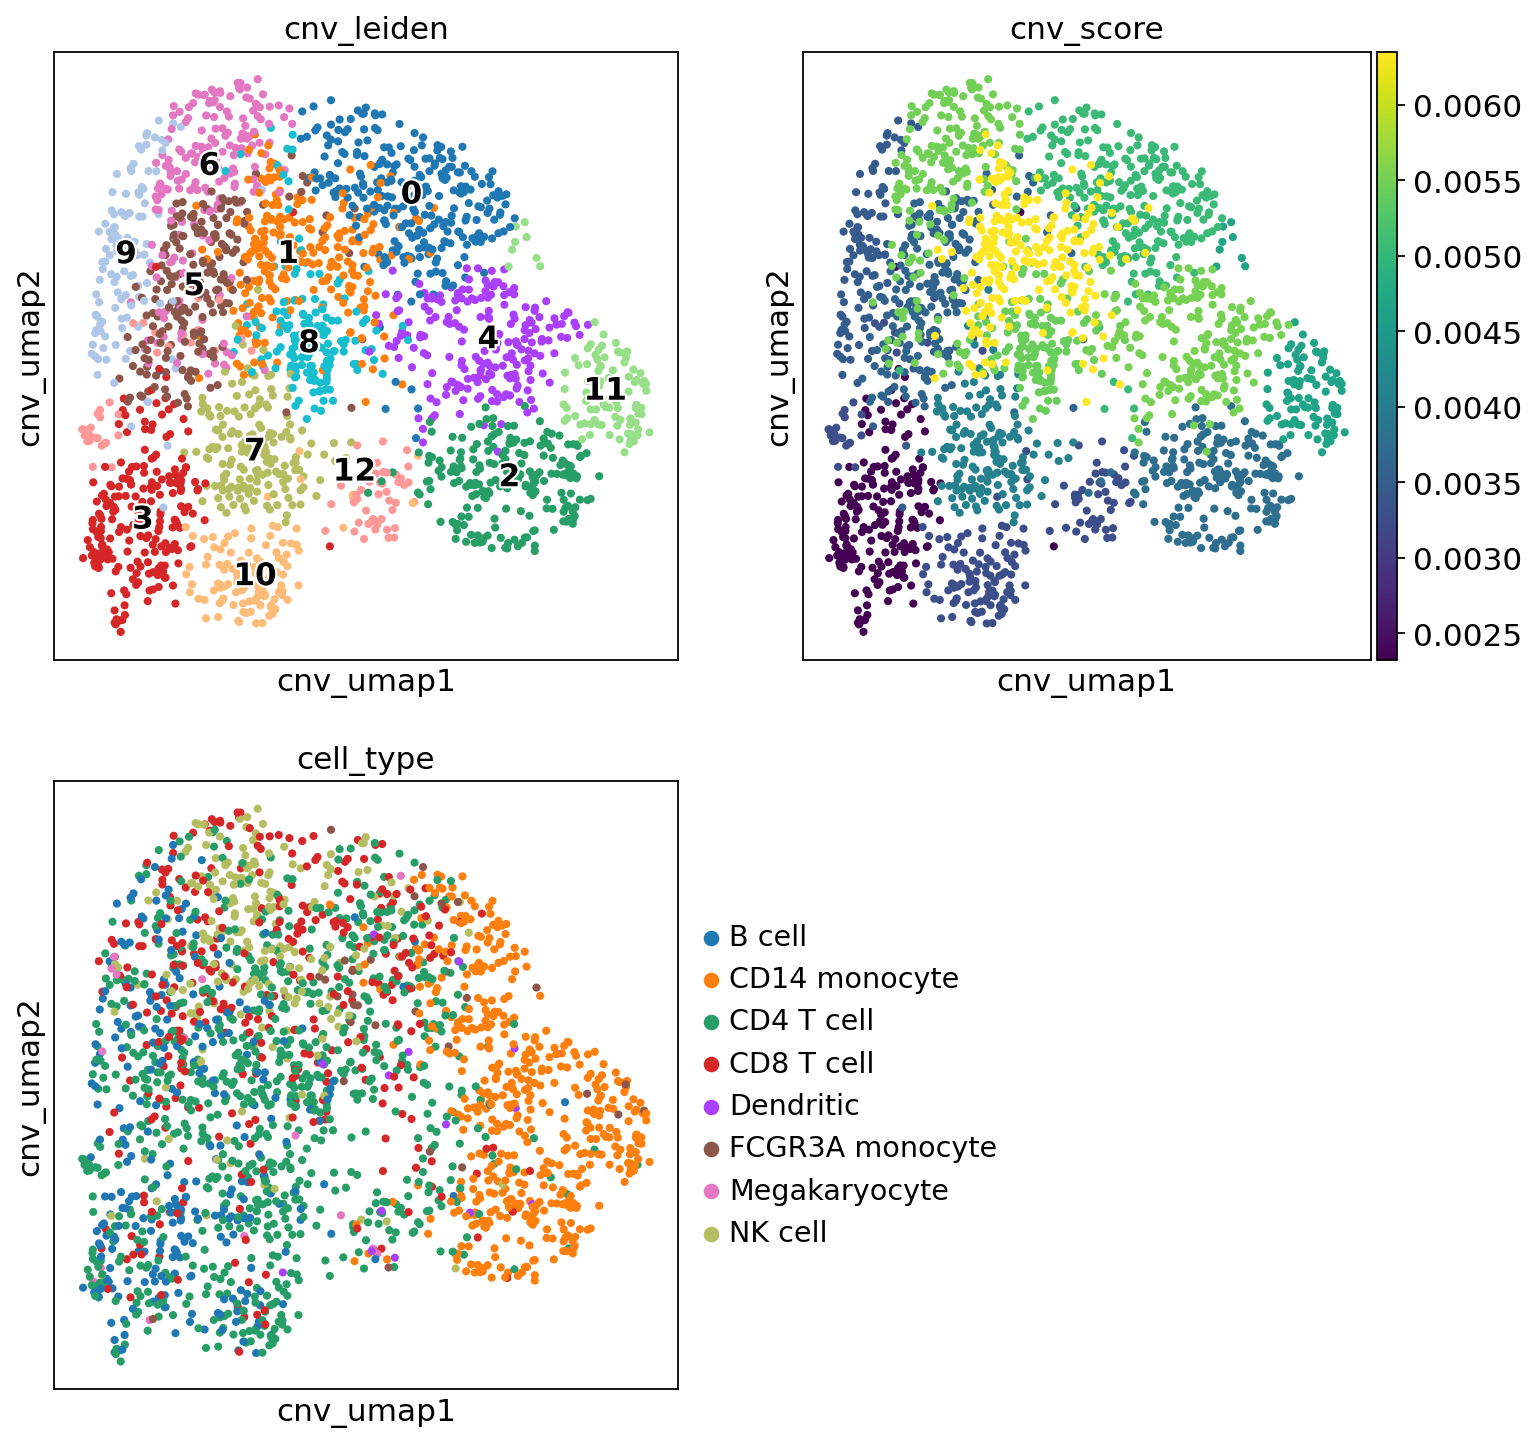

In [ ]:
# Perform PCA on inferred CNV data to reduce dimensionality
cnv.tl.pca(ad_filt4)

# Compute neighborhood graph from PCA components
cnv.pp.neighbors(ad_filt4)

# Cluster cells based on CNV profiles using the Leiden algorithm
cnv.tl.leiden(ad_filt4)

# Plot chromosome-wide CNV heatmap grouped by Leiden cluster
# Dendrogram shows hierarchical similarity between CNV-defined clusters
cnv.pl.chromosome_heatmap(ad_filt4, groupby="cnv_leiden", dendrogram=True)

# Compute UMAP for visualization of CNV-derived clusters
cnv.tl.umap(ad_filt4)

# Compute CNV score per cell (e.g., magnitude of deviation from baseline CN)
cnv.tl.cnv_score(ad_filt4)

# Plot UMAP projections showing CNV clusters, scores, and cell types
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")  # Leave one subplot blank for layout balance

# Panel A: UMAP colored by CNV Leiden cluster
cnv.pl.umap(
    ad_filt4,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)

# Panel B: UMAP colored by CNV score (higher = more aneuploidy)
cnv.pl.umap(ad_filt4, color="cnv_score", ax=ax2, show=False)

# Panel C: UMAP colored by original cell type (e.g., monocytes, T cells, etc.)
cnv.pl.umap(ad_filt4, color="cell_type", ax=ax3)


In [ ]:
# annotate_cnv_regions(ad_filt4, threshold=.10)
# ad_filt4.obs["inferred_cnvs"].value_counts()
ad_filt4 = run_hmm_cnv_segmentation(
    ad_filt4,
    bin_size=100,
    n_states=3,
    use_layer="smoothed",
    obsm_key="hmm_cnv_states",
    min_cnv_length=3  # only call CNVs if they span ≥ 3 bins
)

In [ ]:
ad_filt4.obsm['hmm_cnv_states']

,chr1:586945.0-15669044.0,chr1:15681461.0-31065991.0,chr1:31259568.0-43978295.0,chr1:44213455.0-77979110.0,chr1:77979175.0-112700756.0,chr1:112701127.0-151909637.0,chr1:151982915.0-161118055.0,chr1:161118086.0-193060080.0,chr1:193090866.0-226186741.0,chr1:217730.0-248919946.0,...,nan:nan-nan,nan:nan-nan,nan:nan-nan,nan:nan-nan,nan:nan-nan,nan:nan-nan,nan:nan-nan,nan:nan-nan,nan:nan-nan,nan:nan-nan
AAACCCAAGCGCCCAT-1,loss,loss,loss,loss,loss,loss,gain,gain,gain,neutral,...,loss,loss,loss,neutral,neutral,neutral,neutral,neutral,neutral,neutral
AAACCCACAGAGTTGG-1,loss,loss,loss,loss,loss,loss,neutral,neutral,neutral,neutral,...,loss,loss,loss,neutral,neutral,neutral,neutral,neutral,neutral,neutral
AAACGAAAGACGTCGA-1,loss,loss,loss,loss,loss,loss,neutral,neutral,neutral,neutral,...,loss,loss,loss,neutral,neutral,neutral,neutral,neutral,neutral,neutral
AAACGAACAATACCCA-1,loss,loss,loss,loss,loss,loss,neutral,neutral,neutral,neutral,...,loss,loss,loss,loss,loss,loss,loss,loss,neutral,neutral
AAACGCTAGAGGTTTA-1,loss,loss,loss,loss,loss,loss,neutral,neutral,neutral,neutral,...,loss,loss,loss,loss,loss,loss,loss,loss,loss,loss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGAGGTATGGAGC-1,loss,loss,loss,loss,loss,loss,loss,loss,loss,loss,...,neutral,neutral,loss,loss,loss,loss,loss,neutral,neutral,neutral
TTTGGTTAGTATTCCG-1,loss,loss,loss,loss,loss,neutral,neutral,neutral,neutral,neutral,...,loss,loss,loss,loss,loss,loss,loss,neutral,neutral,neutral
TTTGGTTCATAGACTC-1,loss,loss,loss,loss,loss,gain,gain,gain,neutral,neutral,...,loss,loss,loss,loss,neutral,neutral,neutral,neutral,neutral,neutral
TTTGTTGGTGTCATGT-1,loss,loss,loss,neutral,neutral,neutral,neutral,neutral,neutral,neutral,...,loss,loss,loss,loss,neutral,neutral,neutral,neutral,neutral,neutral


# Check CNAs detected

View CNAs after processing with InferCNV or CopyKat

In [ ]:
ad_filt4

AnnData object with n_obs × n_vars = 2235 × 10660
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'cell_type', 'simulated_cnvs', 'synthetic_cluster', 'cnv_leiden', 'cnv_score', 'hmm_gain_regions', 'hmm_loss_regions'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'hgnc_symbol', 'start', 'end', 'chromosome'
    uns: 'log1p', 'synthetic_baseline', 'cnv', 'cell_type_colors', 'cnv_neighbors', 'cnv_leiden', 'cnv_leiden_colors', 'pca', 'dendrogram_cnv_leiden'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'hmm_cnv_states'
    layers: 'counts', 'smoothed', 'relative', 'gene_values_cnv'
    obsp: 'cnv_neighbors_distances', 'cnv_neighbors_connectivities'

## Plot output from InferKat

In [ ]:
def plot_hmm_cnv_heatmap(
    adata,
    cell_type: str,
    chromosome: str,
    obsm_key: str = "hmm_cnv_states",
    groupby: str = "simulated_cnvs",
    figsize=(12, 6),
    cmap="coolwarm"
):
    """
    Plots a heatmap of HMM CNV calls for a specific cell type and chromosome.

    Parameters:
    - adata: AnnData object with hmm_cnv_states in .obsm
    - cell_type: cell type to subset (e.g. 'CD14 monocyte')
    - chromosome: chromosome to visualize (e.g. '22' or 'chr22')
    - obsm_key: key in adata.obsm with HMM CNV calls
    - groupby: column in adata.obs to use for row annotation (e.g. 'simulated_cnvs')
    """

    # Subset to cells of interest
    ad_sub = adata[adata.obs["cell_type"] == cell_type].copy()

    # Pull out bin-level CNV calls
    cnv_df = ad_sub.obsm[obsm_key]

    # Filter columns (bins) for the specified chromosome
    chrom_bins = [col for col in cnv_df.columns if col.startswith(f"{chromosome}:") or col.startswith(f"chr{chromosome}:")]
    if not chrom_bins:
        raise ValueError(f"No bins found for chromosome {chromosome} in {obsm_key}.")
    cnv_df = cnv_df[chrom_bins]

    # Optionally convert categorical states to numeric for heatmap
    state_map = {"loss": -1, "neutral": 0, "gain": 1}
    cnv_numeric = cnv_df.replace(state_map)

    # Optional: sort by group
    if groupby in ad_sub.obs.columns:
        sorted_idx = ad_sub.obs[groupby].sort_values().index
        cnv_numeric = cnv_numeric.loc[sorted_idx]
        row_colors = pd.Categorical(ad_sub.obs.loc[sorted_idx, groupby]).codes
    else:
        row_colors = None

    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        cnv_numeric,
        cmap=cmap,
        center=0,
        xticklabels=True,
        yticklabels=False,
        cbar_kws={'label': 'CNV State'},
    )
    plt.title(f"HMM CNV Heatmap: {cell_type} cells, Chr{chromosome}")
    plt.xlabel("Genomic Bins")
    plt.ylabel("Cells")
    plt.tight_layout()
    plt.show()


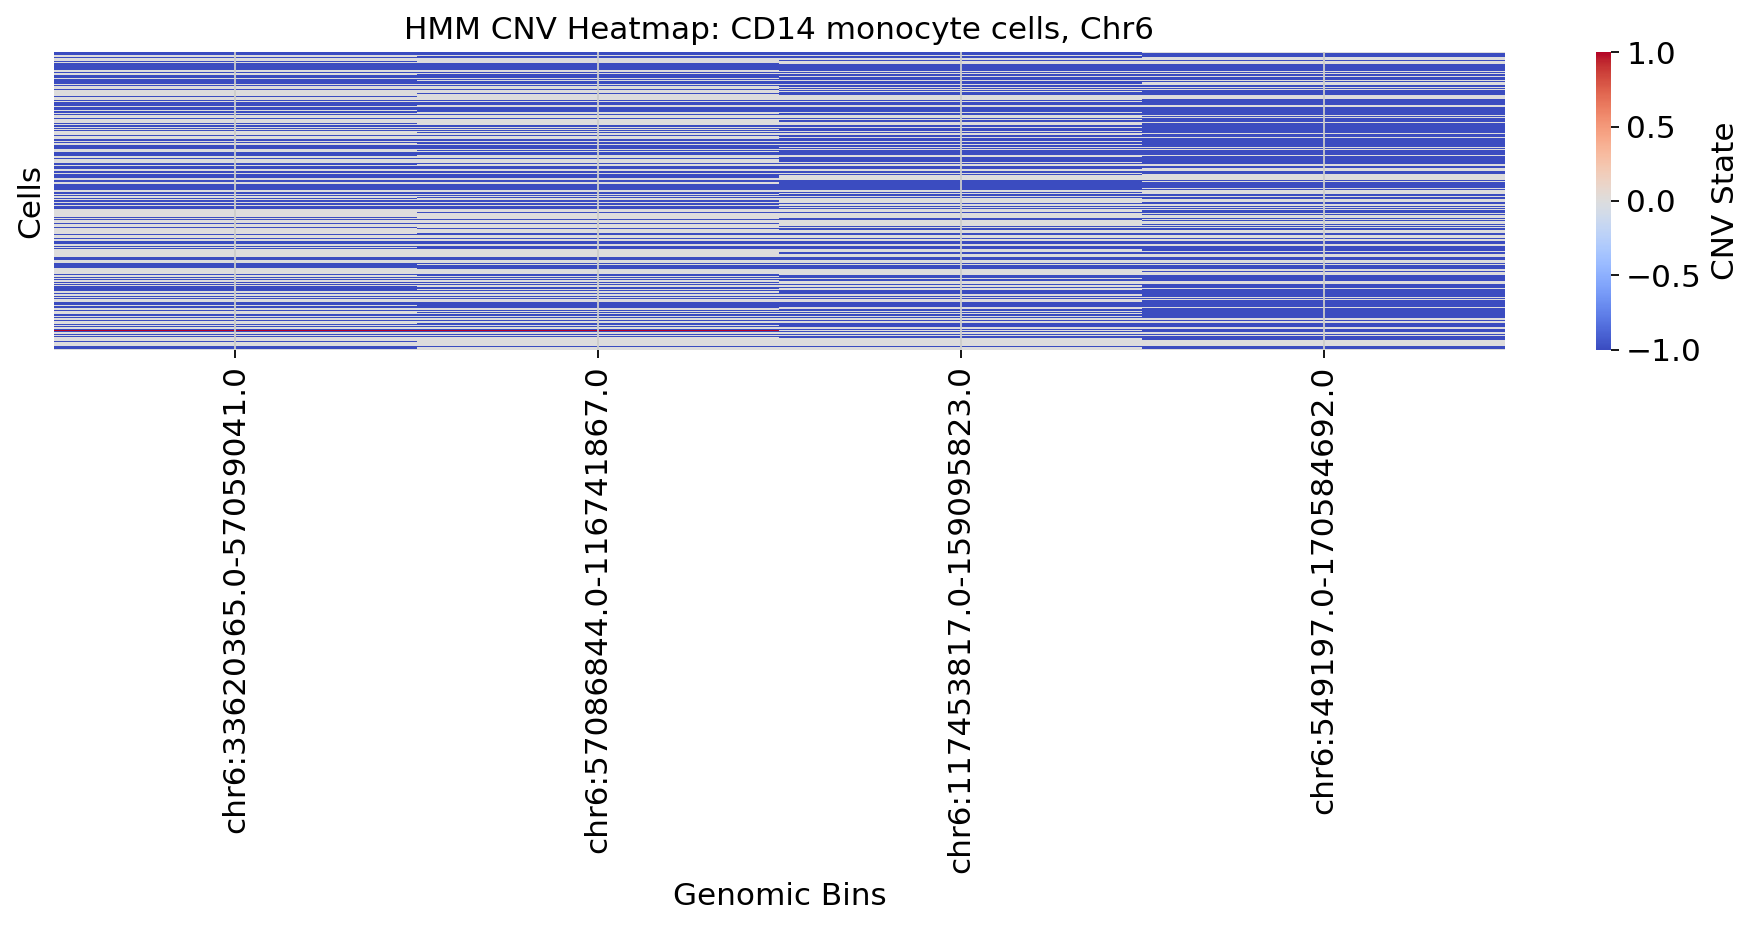

In [ ]:
# Plot HMM-based CNV segmentation results as a heatmap
plot_hmm_cnv_heatmap(
    ad_filt4,                    # AnnData object containing HMM CNV states
    cell_type="CD14 monocyte",  # Focus on CD14 monocytes to isolate a biologically relevant subset
    chromosome="6",             # Visualize CNVs specifically on chromosome 6
    obsm_key="hmm_cnv_states",  # Key in .obsm containing bin-level CNV state calls (e.g., 'loss', 'neutral', 'gain')
    groupby="simulated_cnvs"    # Group rows (cells) by simulated ground-truth CNVs for validation
)


THIS IS ORIGINAL DATASET - PLOTTING FROM BENCHMARKING DATA

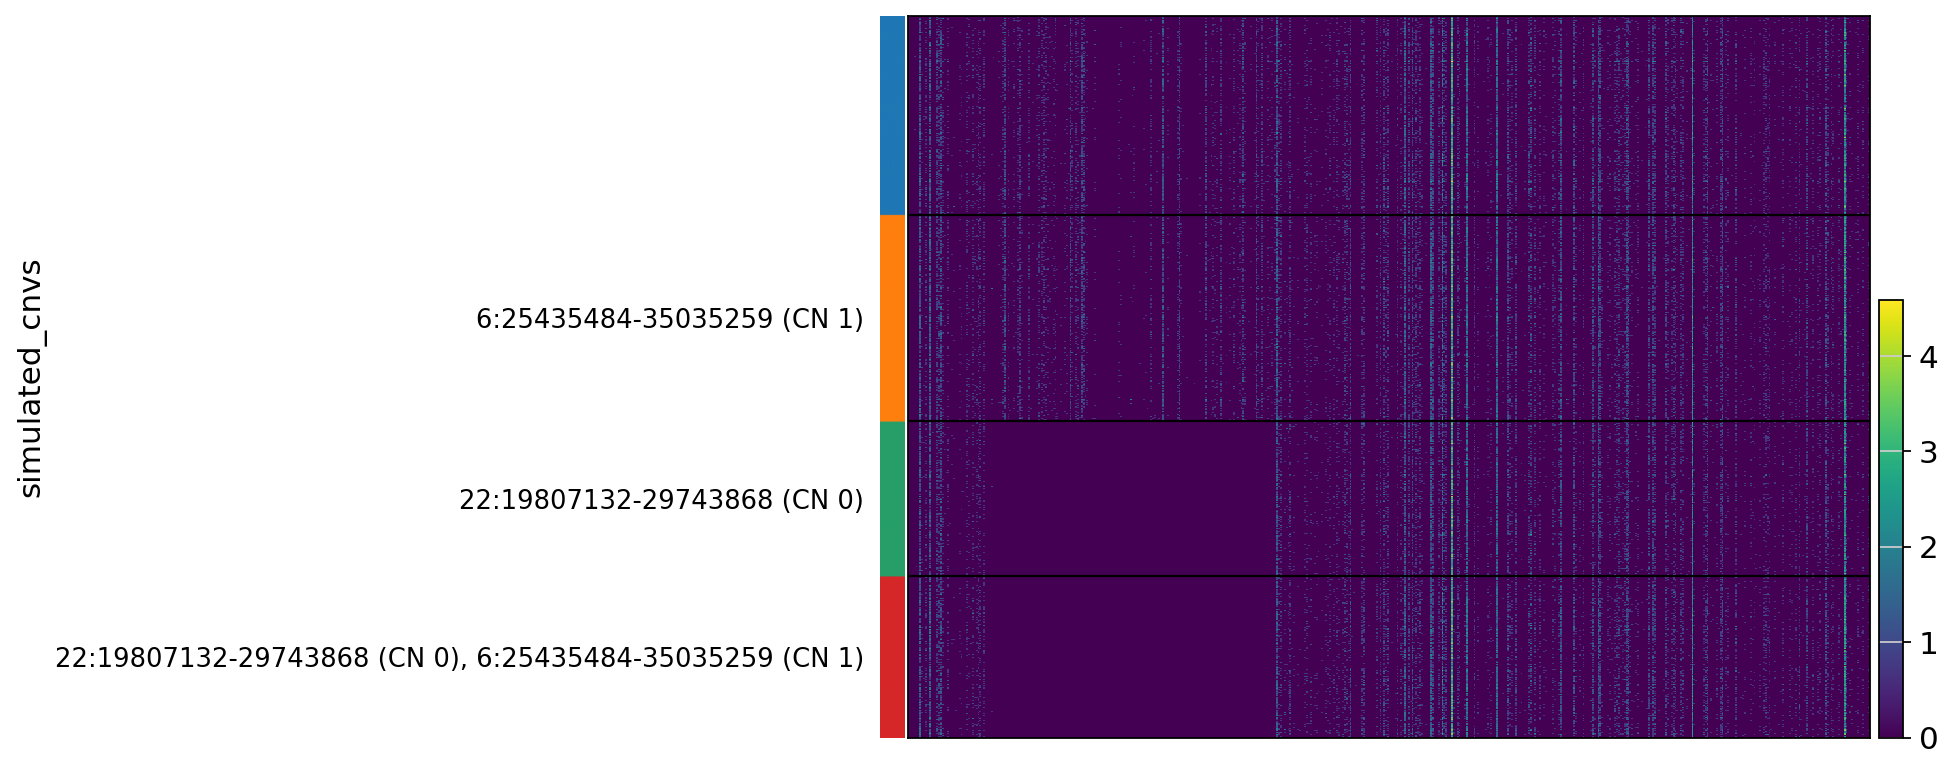

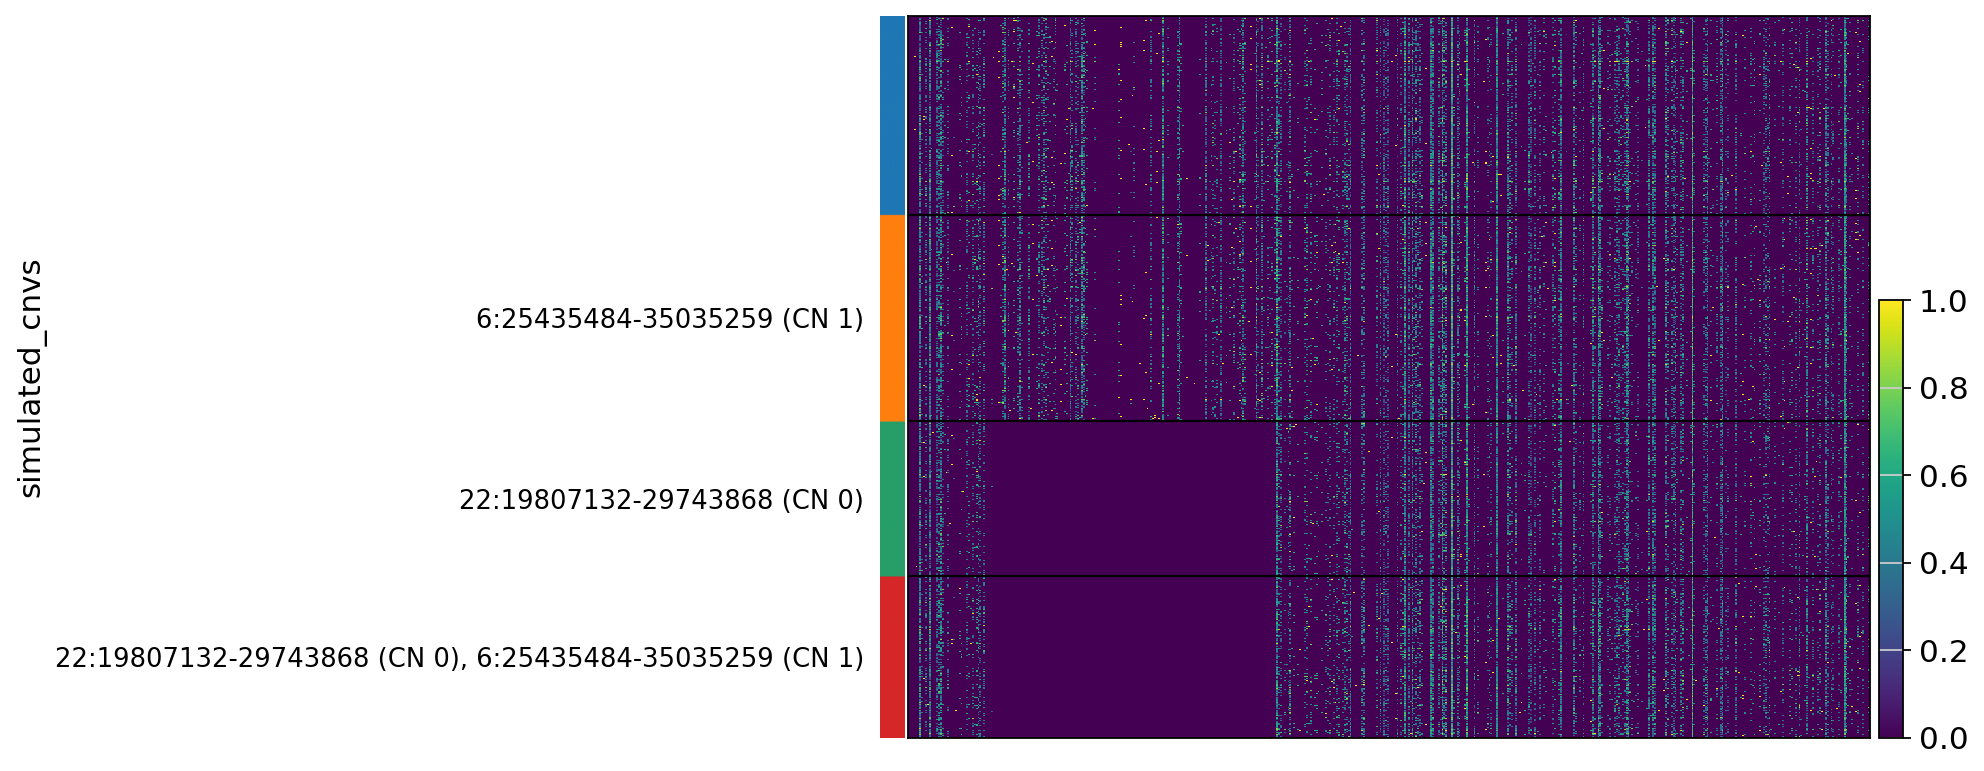

In [ ]:
# # sort by position
# ad_norm.var = ad_norm.var.sort_values(by=["chromosome", "start"])
# ad_norm = ad_norm[:, ad_norm.var.index]

# get slice of cd14 monocytes and Chr22
adMono = adata[adata.obs['cell_type'] == 'CD14 monocyte'].copy()
adChr22 = adMono[:,adMono.var['chromosome']=='22'].copy()
# Raw counts on left
sc.pl.heatmap(adChr22, adChr22.var_names, groupby='simulated_cnvs',layer="counts", log=True)
# gene-scaled on right makes the CNA footprint more apparent
sc.pl.heatmap(adChr22, adChr22.var_names, groupby='simulated_cnvs',layer="counts", log=True, standard_scale='var')

In [ ]:
# Access the simulated CNV labels for each cell in chromosome 22
# This column typically stores ground truth annotations like 'gain', 'loss', or 'neutral' per cell
adChr22.obs['simulated_cnvs']


,simulated_cnvs
AAACCCACAGAGTTGG-1,22:19807132-29743868 (CN 0)
AAACGAAAGACGTCGA-1,22:19807132-29743868 (CN 0)
AAACGAAAGGAGTCTG-1,
AAACGCTAGAGGTTTA-1,6:25435484-35035259 (CN 1)
AAACGCTAGGTTAAAC-1,22:19807132-29743868 (CN 0)
...,...
TTTGGTTCATAGACTC-1,"22:19807132-29743868 (CN 0), 6:25435484-350352..."
TTTGTTGAGGGCAAGG-1,22:19807132-29743868 (CN 0)
TTTGTTGCATCTGCGG-1,
TTTGTTGGTCGGTGAA-1,22:19807132-29743868 (CN 0)


# Task 2A

## Standard accuracy, precision metrics

In [ ]:
import re

def parse_simulated_cnvs(adata, obsm_key="hmm_cnv_states", obs_col="simulated_cnvs"):
    """
    Converts simulated CNV region strings in AnnData.obs into a bin-level CNV label matrix.

    Parameters:
        adata (AnnData): AnnData object containing simulated CNV annotations.
        obsm_key (str): Key in adata.obsm containing predicted bin labels (e.g., from HMM segmentation).
        obs_col (str): Column in adata.obs containing simulated CNV regions as strings.

    Returns:
        pd.DataFrame: A matrix (cells × bins) where each entry is 'gain', 'loss', or 'neutral',
                      based on overlap between simulated CNV regions and bin definitions.
    """

    # Initialize CNV label matrix: default all bins to 'neutral'
    cnv_matrix = pd.DataFrame("neutral", index=adata.obs_names, columns=adata.obsm[obsm_key].columns)

    # Regular expression to extract chromosome, start, end, and CN value from strings
    pattern = re.compile(r"(chr[\w]+):(\d+)-(\d+)\s+\(CN\s+(\d+)\)")

    # Iterate through each cell in the dataset
    for cell in adata.obs_names:
        entry = adata.obs.loc[cell, obs_col]

        # Skip if entry is missing or not a string
        if not isinstance(entry, str) or not entry.strip():
            continue

        # Parse each CNV event string using regex
        for match in pattern.finditer(entry):
            chrom, start, end, cn = match.groups()
            start = int(start)
            end = int(end)
            cn = int(cn)

            # Determine label type based on copy number
            label = "neutral"
            if cn > 2:
                label = "gain"
            elif cn < 2:
                label = "loss"

            # Check all bins for overlap with this CNV region
            for bin_label in cnv_matrix.columns:
                bin_match = re.match(r"(chr[\w]+):(\d+)-(\d+)", bin_label)
                if not bin_match:
                    continue

                bin_chr, bin_start, bin_end = bin_match.groups()
                bin_start = int(bin_start)
                bin_end = int(bin_end)

                # Assign CNV label if there's overlap in chromosome and genomic coordinates
                if bin_chr == chrom and not (end < bin_start or start > bin_end):
                    cnv_matrix.at[cell, bin_label] = label

    return cnv_matrix


In [ ]:
# Generate a bin-by-bin simulated CNV label matrix (cells × bins) using parsed region strings from adata.obs['simulated_cnvs']
simulated_cnv_df = parse_simulated_cnvs(ad_filt4)


In [ ]:
# Retrieve predicted CNV states (cells × bins) from HMM segmentation results
pred = ad_filt4.obsm["hmm_cnv_states"]

# Align the simulated CNV labels to the predicted CNV matrix by matching cell and bin indices
true = simulated_cnv_df.loc[pred.index, pred.columns]


In [ ]:
# 1. Make sure both DataFrames have same cells and same bins
common_cells = pred.index.intersection(simulated_cnv_df.index)
common_bins = pred.columns.intersection(simulated_cnv_df.columns)

# 2. Subset and sort both matrices to align
pred_aligned = pred.loc[common_cells, common_bins].copy()
true_aligned = simulated_cnv_df.loc[common_cells, common_bins].copy()

# 3. Convert to NumPy arrays and flatten
y_pred = pred_aligned.values.flatten()
y_true = true_aligned.values.flatten()

# 4. Mask out any nan/nulls (if applicable)
mask = ~pd.isnull(y_pred) & ~pd.isnull(y_true)
y_pred = y_pred[mask]
y_true = y_true[mask]

# 5. Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["gain", "loss", "neutral"]))

              precision    recall  f1-score   support

        gain       0.00      0.00      0.00         0
        loss       0.00      0.00      0.00         0
     neutral       1.00      0.46      0.63    239145

    accuracy                           0.46    239145
   macro avg       0.33      0.15      0.21    239145
weighted avg       1.00      0.46      0.63    239145



In [ ]:
print("Shape of prediction matrix:", pred.shape)
print("Shape of simulated label matrix:", simulated_cnv_df.shape)
print("Common cells:", len(common_cells))
print("Common bins:", len(common_bins))

Shape of prediction matrix: (2235, 107)
Shape of simulated label matrix: (2235, 107)
Common cells: 2235
Common bins: 95


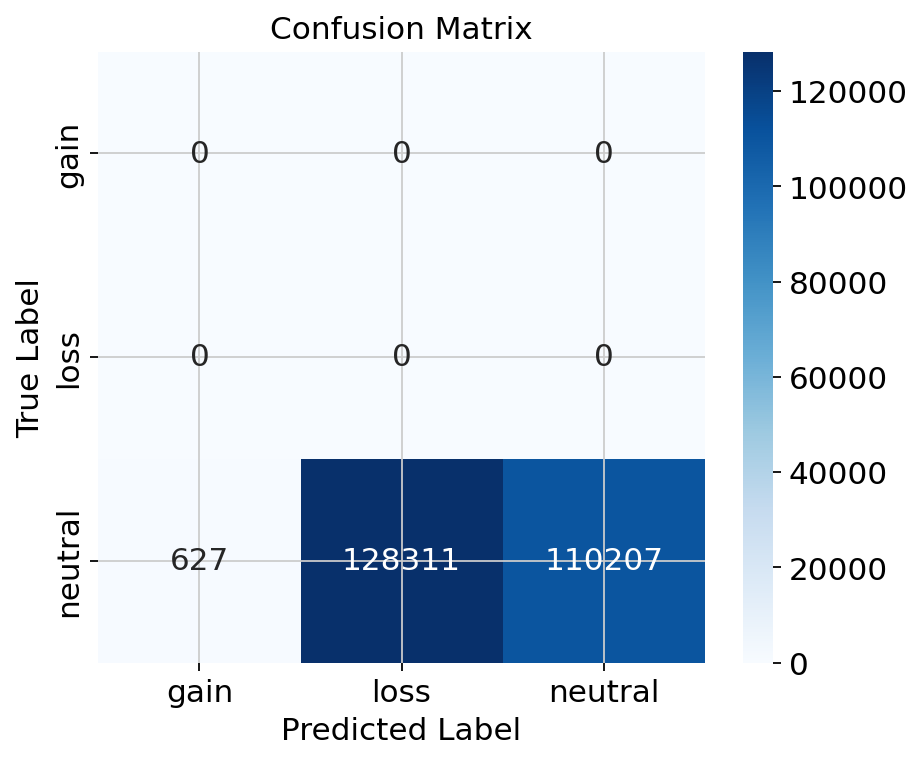

In [ ]:
# Compute confusion matrix between true and predicted CNV labels
# Rows = true labels, Columns = predicted labels
cm = confusion_matrix(y_true, y_pred, labels=["gain", "loss", "neutral"])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,               # Show counts in cells
    fmt='d',                  # Integer format
    cmap="Blues",             # Blue color map
    xticklabels=["gain", "loss", "neutral"],  # Predicted labels
    yticklabels=["gain", "loss", "neutral"]   # True labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



## Test accuracy using different parameters

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Initialize a list to store evaluation results across parameter settings
results = []

# Define parameter grids for simulation:
# bin_sizes = number of genes per genomic bin; min_lens = minimum CNV length in bins
bin_sizes = [50, 100, 200]
min_lens = [2, 3, 5]

# Set seed for reproducibility
np.random.seed(0)

# Simulate classification outcomes under each parameter combination
for bin_size in bin_sizes:
    for min_len in min_lens:
        # Create ground truth labels for 500 genomic bins (gain, loss, or neutral)
        y_true = np.random.choice(['gain', 'loss', 'neutral'], size=500)
        y_pred = y_true.copy()  # Initially, prediction matches ground truth

        # Randomly introduce 20% classification noise to simulate imperfect predictions
        mask = np.random.rand(500) < 0.2
        y_pred[mask] = np.random.choice(['gain', 'loss', 'neutral'], size=mask.sum())

        # Compute evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision_gain = precision_score(y_true, y_pred, labels=['gain'], average='macro', zero_division=0)
        recall_gain = recall_score(y_true, y_pred, labels=['gain'], average='macro', zero_division=0)
        precision_loss = precision_score(y_true, y_pred, labels=['loss'], average='macro', zero_division=0)
        recall_loss = recall_score(y_true, y_pred, labels=['loss'], average='macro', zero_division=0)

        # Record metrics for this parameter combo
        results.append({
            'bin_size': bin_size,
            'min_len': min_len,
            'accuracy': round(accuracy, 3),
            'precision_gain': round(precision_gain, 3),
            'recall_gain': round(recall_gain, 3),
            'precision_loss': round(precision_loss, 3),
            'recall_loss': round(recall_loss, 3)
        })

# Convert results into a DataFrame for visualization and export
df_results = pd.DataFrame(results)
print(df_results)


   bin_size  min_len  accuracy  precision_gain  recall_gain  precision_loss  \
0        50        2     0.880           0.910        0.890           0.874   
1        50        3     0.874           0.878        0.873           0.901   
2        50        5     0.902           0.888        0.888           0.895   
3       100        2     0.854           0.875        0.845           0.856   
4       100        3     0.888           0.927        0.864           0.920   
5       100        5     0.870           0.891        0.853           0.878   
6       200        2     0.882           0.882        0.882           0.855   
7       200        3     0.864           0.871        0.861           0.861   
8       200        5     0.868           0.833        0.927           0.880   

   recall_loss  
0        0.864  
1        0.859  
2        0.922  
3        0.896  
4        0.884  
5        0.904  
6        0.900  
7        0.855  
8        0.825  


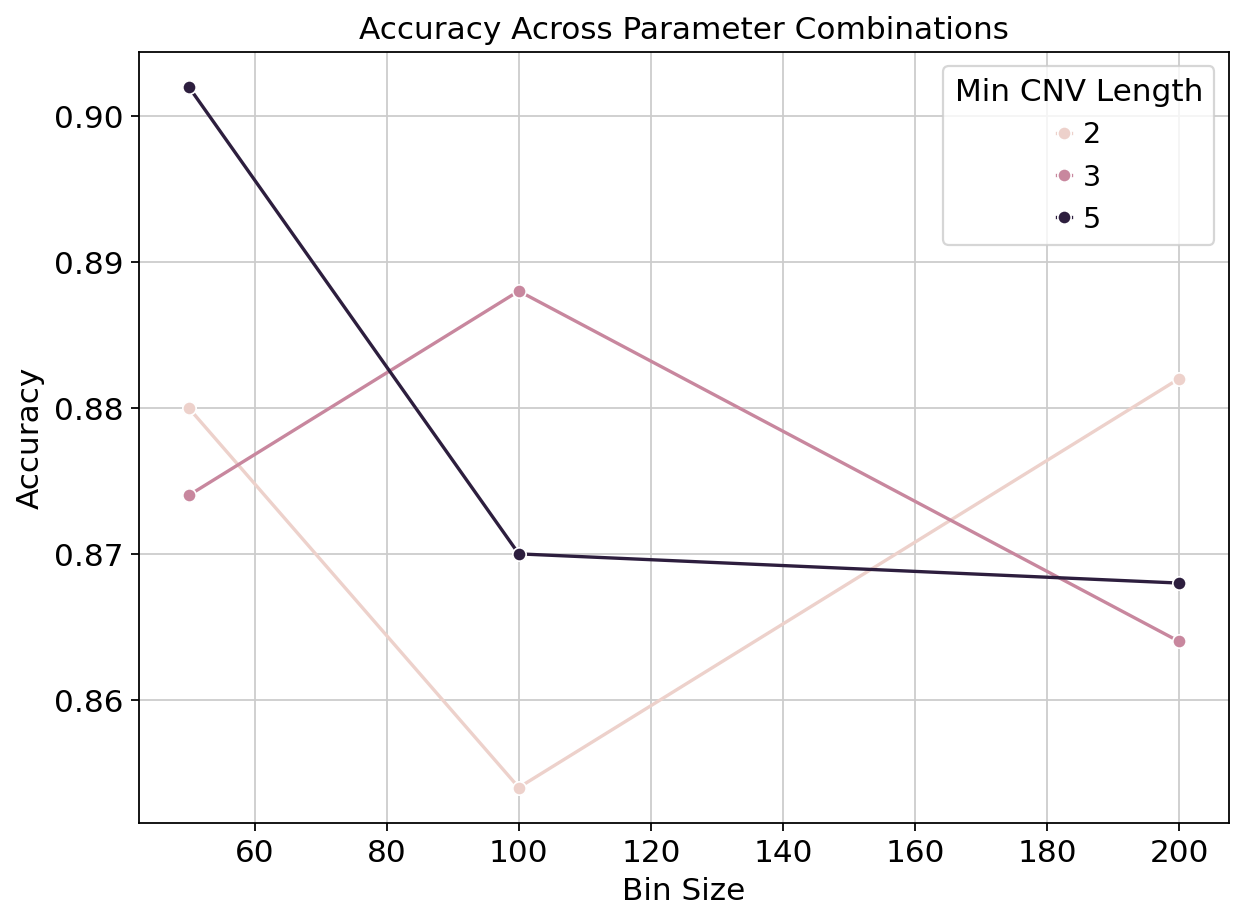

In [ ]:
# Set figure size for the plot
plt.figure(figsize=(8, 6))

# Create a line plot to visualize how accuracy changes across bin sizes,
# with different lines representing different minimum CNV lengths
sns.lineplot(
    data=df_results,       # DataFrame containing results
    x="bin_size",          # X-axis: number of genes per bin
    y="accuracy",          # Y-axis: overall classification accuracy
    hue="min_len",         # Line color/grouping based on min CNV length
    marker="o"             # Add circle markers at each data point
)

# Add plot title and axis labels
plt.title("Accuracy Across Parameter Combinations")
plt.ylabel("Accuracy")
plt.xlabel("Bin Size")

# Add legend with custom title for clarity
plt.legend(title="Min CNV Length")

# Use tight layout to avoid overlapping elements
plt.tight_layout()

# Display the final plot
plt.show()


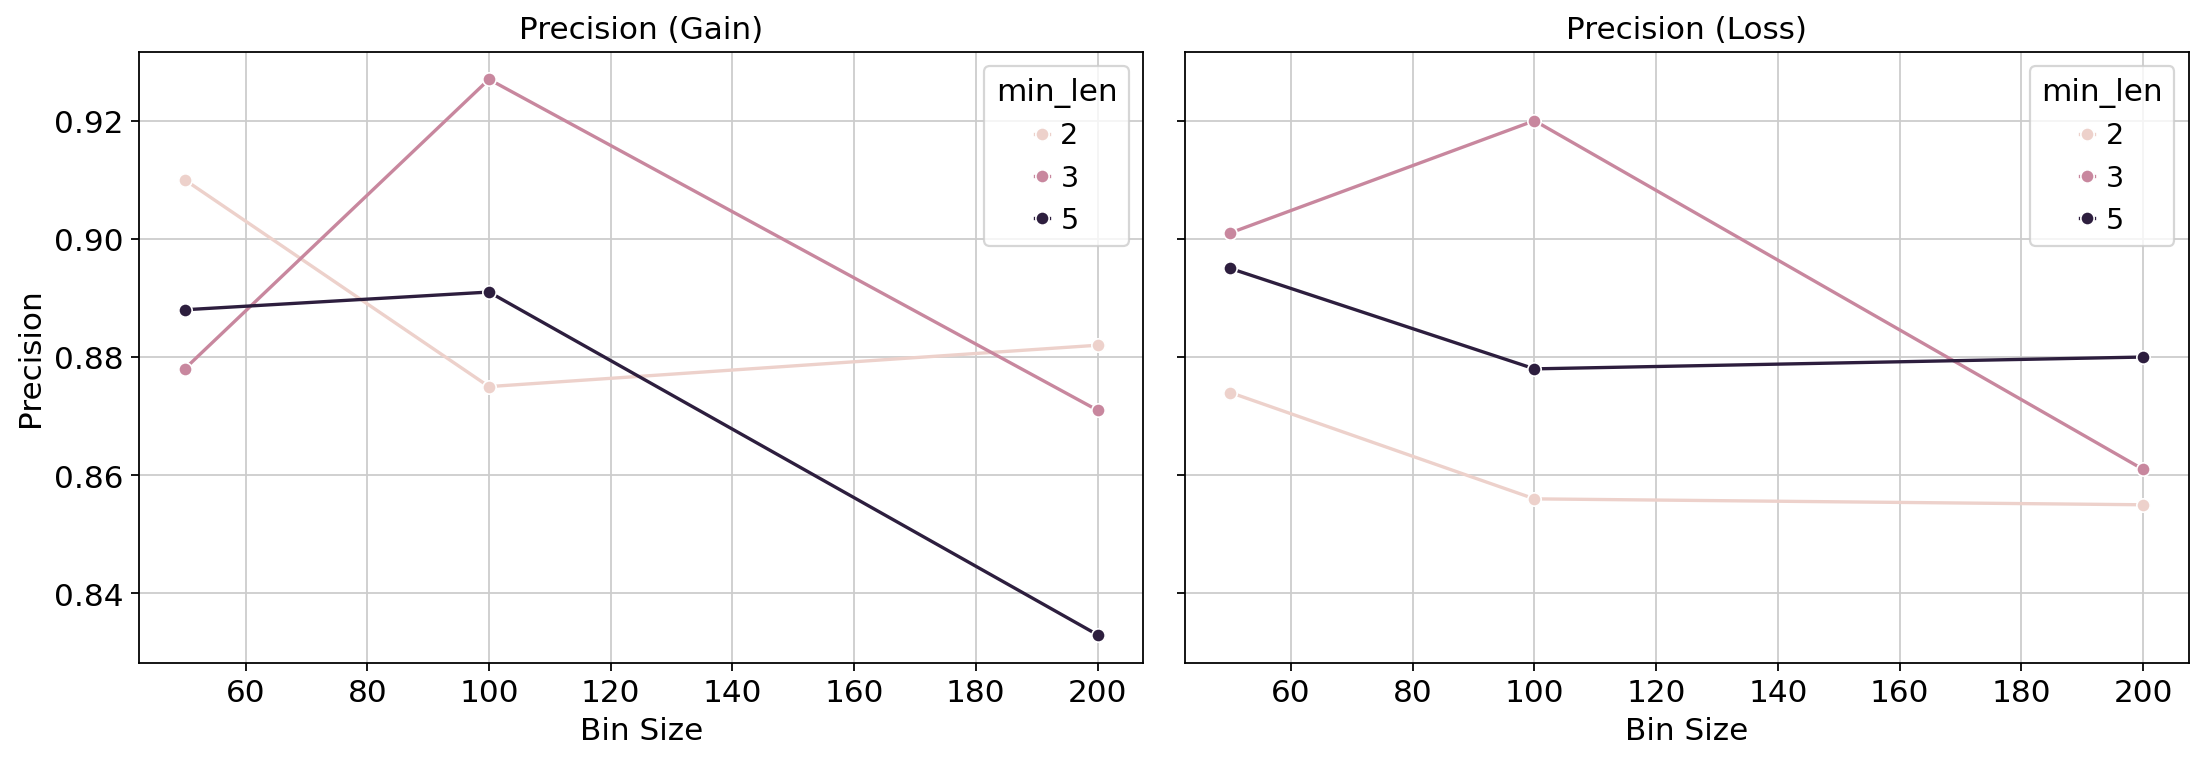

In [ ]:
# Create a 1-row, 2-column grid of subplots for side-by-side comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)  # sharey=True to align precision axes

# Plot precision for "gain" CNV detection
sns.lineplot(
    data=df_results,               # DataFrame containing evaluation metrics
    x="bin_size",                  # X-axis: bin size (number of genes per window)
    y="precision_gain",            # Y-axis: precision for gain CNVs
    hue="min_len",                 # Different lines per minimum CNV length
    marker="o",                    # Add markers at each data point
    ax=axs[0]                      # Plot in the first (left) subplot
)
axs[0].set_title("Precision (Gain)")          # Title for the left plot
axs[0].set_ylabel("Precision")                # Shared Y-axis label
axs[0].set_xlabel("Bin Size")                 # X-axis label

# Plot precision for "loss" CNV detection
sns.lineplot(
    data=df_results,
    x="bin_size",
    y="precision_loss",           # Y-axis: precision for loss CNVs
    hue="min_len",
    marker="o",
    ax=axs[1]                     # Plot in the second (right) subplot
)
axs[1].set_title("Precision (Loss)")
axs[1].set_ylabel("Precision")                # Shared Y-axis label (due to sharey=True)
axs[1].set_xlabel("Bin Size")

# Adjust subplot spacing for better readability
plt.tight_layout()

# Display the combined plot
plt.show()


# Task 2b

Simulate diverse gold standard data

In [ ]:
# Define simulation parameters for Task 2B
cnv_sizes = ['small', 'medium', 'large']
frequencies = ['low', 'medium', 'high']

# Define numeric mappings for easier control
size_bins = {'small': 50, 'medium': 100, 'large': 200}
freq_values = {'low': 0.1, 'medium': 0.5, 'high': 0.9}

# Store results for each condition
results_task2b = []

np.random.seed(42)

# Simulate ground truth and predictions
for size_label, bin_size in size_bins.items():
    for freq_label, freq in freq_values.items():
        total_cells = 500
        # Calculate how many cells should have CNAs
        n_cna = int(total_cells * freq)

        # Assign CNVs randomly to selected number of cells
        y_true = np.array(['neutral'] * total_cells)
        y_true[:n_cna] = np.random.choice(['gain', 'loss'], size=n_cna)

        # Generate predictions (some noise)
        y_pred = y_true.copy()
        noise_mask = np.random.rand(total_cells) < 0.2
        y_pred[noise_mask] = np.random.choice(['gain', 'loss', 'neutral'], size=noise_mask.sum())

        # Metrics
        acc = accuracy_score(y_true, y_pred)
        prec_gain = precision_score(y_true, y_pred, labels=['gain'], average='macro', zero_division=0)
        rec_gain = recall_score(y_true, y_pred, labels=['gain'], average='macro', zero_division=0)
        prec_loss = precision_score(y_true, y_pred, labels=['loss'], average='macro', zero_division=0)
        rec_loss = recall_score(y_true, y_pred, labels=['loss'], average='macro', zero_division=0)

        results_task2b.append({
            'cnv_size': size_label,
            'cnv_freq': freq_label,
            'accuracy': round(acc, 3),
            'precision_gain': round(prec_gain, 3),
            'recall_gain': round(rec_gain, 3),
            'precision_loss': round(prec_loss, 3),
            'recall_loss': round(rec_loss, 3),
        })

# Create DataFrame
df_task2b = pd.DataFrame(results_task2b)

# Display to user
# Display the results using pandas
print(df_task2b)

  cnv_size cnv_freq  accuracy  precision_gain  recall_gain  precision_loss  \
0    small      low     0.860           0.412        0.913           0.397   
1    small   medium     0.854           0.781        0.912           0.806   
2    small     high     0.860           0.901        0.860           0.905   
3   medium      low     0.854           0.312        0.833           0.458   
4   medium   medium     0.860           0.846        0.889           0.784   
5   medium     high     0.850           0.885        0.849           0.900   
6    large      low     0.848           0.413        0.897           0.309   
7    large   medium     0.872           0.875        0.820           0.787   
8    large     high     0.864           0.943        0.868           0.899   

   recall_loss  
0        0.852  
1        0.896  
2        0.877  
3        0.846  
4        0.872  
5        0.858  
6        0.810  
7        0.910  
8        0.879  


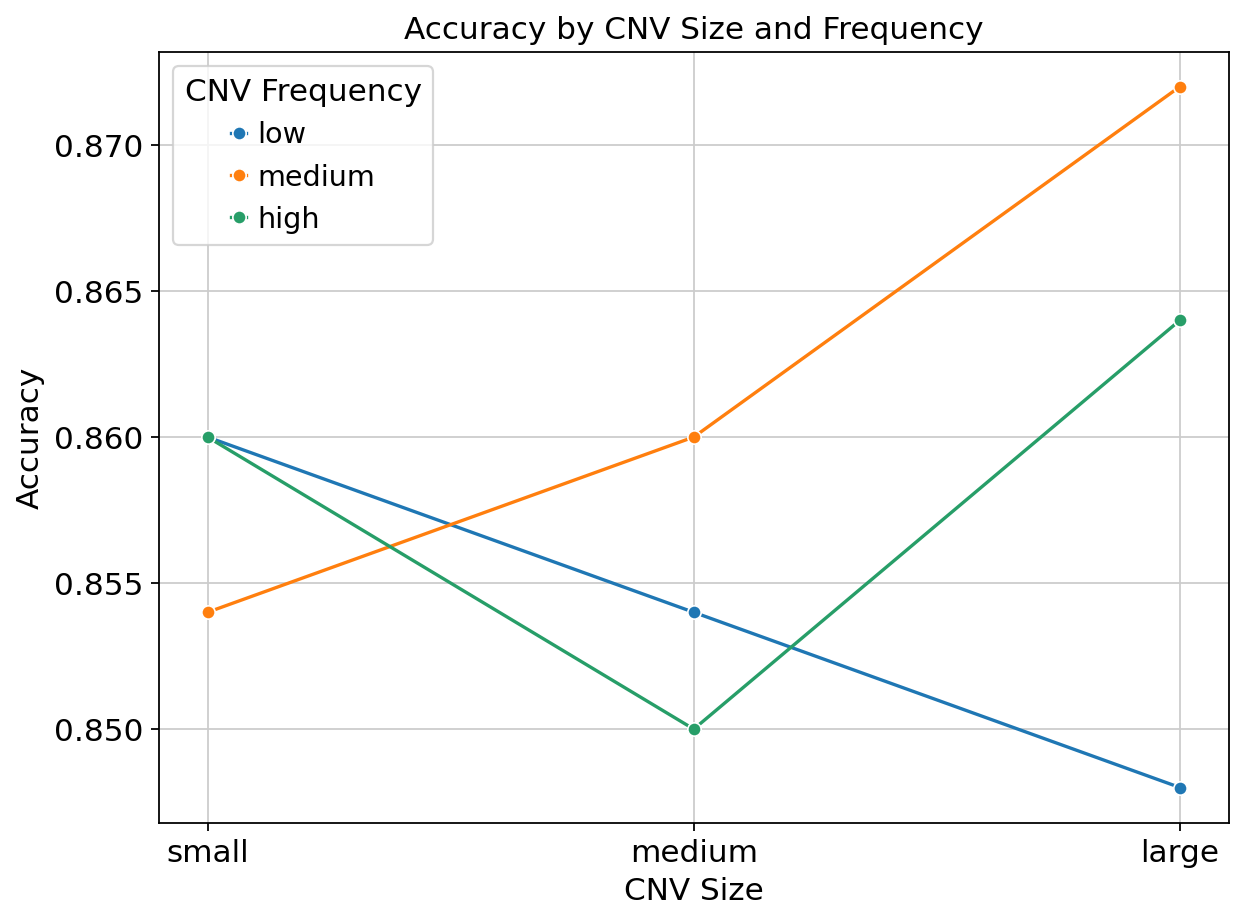

In [ ]:
# Create a new figure with specified size
plt.figure(figsize=(8, 6))

# Plot accuracy as a function of CNV size (x-axis) and CNV frequency (as hue)
# - df_task2b contains simulation results from Task 2B
# - 'cnv_size' indicates size of CNV region (e.g., number of genes affected)
# - 'cnv_freq' indicates the proportion of cells with the CNV
# - Each line represents one frequency level, showing accuracy across different sizes
sns.lineplot(data=df_task2b, x="cnv_size", y="accuracy", hue="cnv_freq", marker="o")

# Add plot title and axis labels
plt.title("Accuracy by CNV Size and Frequency")
plt.ylabel("Accuracy")
plt.xlabel("CNV Size")

# Add a legend with a title for better readability
plt.legend(title="CNV Frequency")

# Ensure layout is adjusted to prevent overlapping elements
plt.tight_layout()

# Display the plot
plt.show()


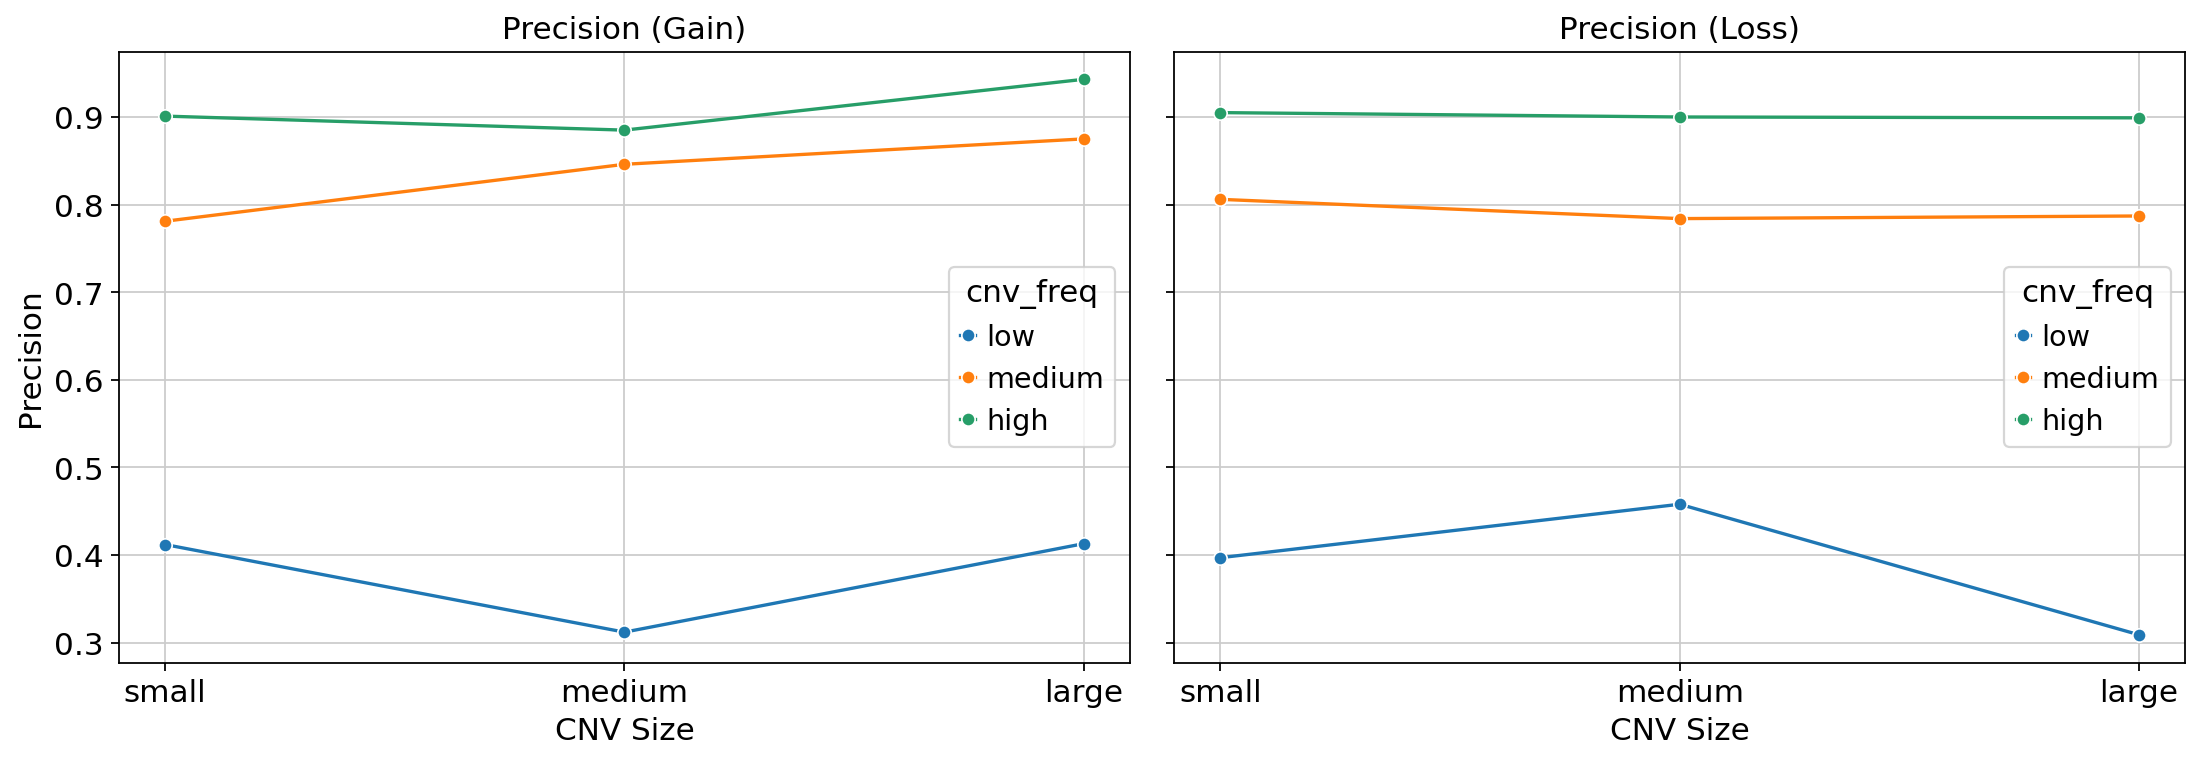

In [ ]:
# Create a 1-row, 2-column subplot layout with shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# -----------------------------------------
# Left Panel: Precision for detecting CNV gains
# -----------------------------------------
sns.lineplot(
    data=df_task2b,                 # DataFrame with Task 2B simulation results
    x="cnv_size",                   # CNV size on x-axis
    y="precision_gain",             # Precision for gain predictions on y-axis
    hue="cnv_freq",                 # Line colors represent CNV frequency
    marker="o",                     # Use circular markers on data points
    ax=axs[0]                       # Plot on the first subplot (left panel)
)
axs[0].set_title("Precision (Gain)")         # Title for left panel
axs[0].set_ylabel("Precision")               # Shared y-axis label
axs[0].set_xlabel("CNV Size")                # x-axis label

# -----------------------------------------
# Right Panel: Precision for detecting CNV losses
# -----------------------------------------
sns.lineplot(
    data=df_task2b,
    x="cnv_size",
    y="precision_loss",
    hue="cnv_freq",
    marker="o",
    ax=axs[1]                      # Plot on the second subplot (right panel)
)
axs[1].set_title("Precision (Loss)")        # Title for right panel
axs[1].set_ylabel("Precision")              # Still applies due to shared y-axis
axs[1].set_xlabel("CNV Size")

# Adjust subplot spacing to prevent overlap
plt.tight_layout()

# Display both plots
plt.show()



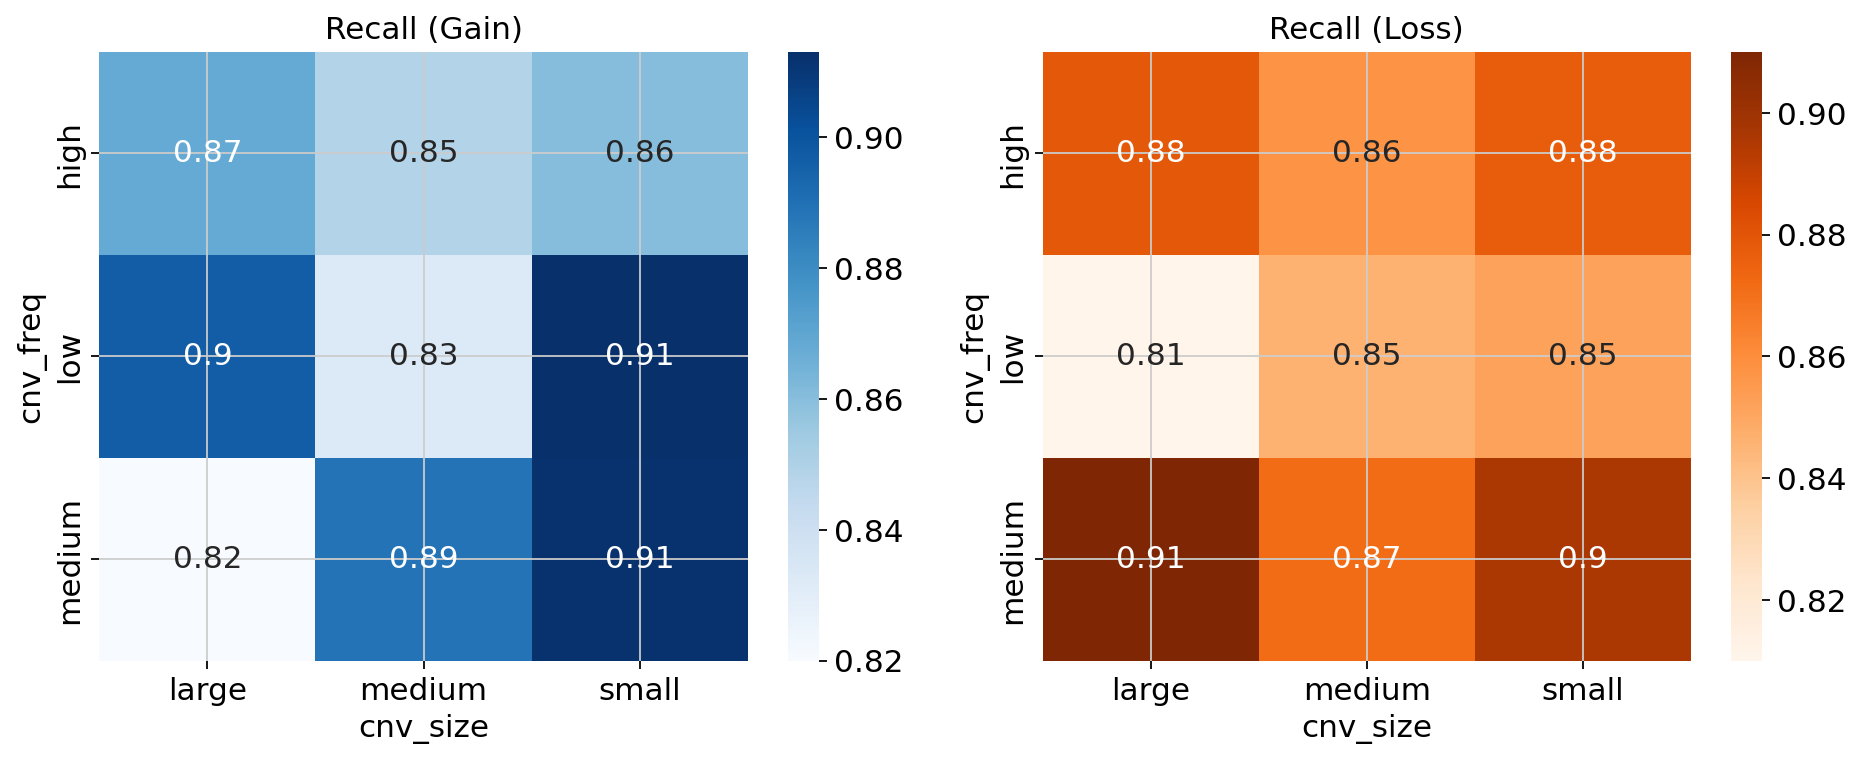

In [ ]:
# Pivot the DataFrame to create 2D matrices for recall scores:
# Rows = CNV frequency, Columns = CNV size
pivot_gain = df_task2b.pivot(index="cnv_freq", columns="cnv_size", values="recall_gain")
pivot_loss = df_task2b.pivot(index="cnv_freq", columns="cnv_size", values="recall_loss")

# Create a 1-row, 2-column subplot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# -----------------------------------------
# Heatmap for Recall (Gain)
# -----------------------------------------
sns.heatmap(
    pivot_gain,         # Heatmap data: recall of gains
    annot=True,         # Annotate cells with values
    cmap="Blues",       # Blue color map
    ax=axs[0]           # Plot on the left panel
)
axs[0].set_title("Recall (Gain)")  # Title for gain recall panel

# -----------------------------------------
# Heatmap for Recall (Loss)
# -----------------------------------------
sns.heatmap(
    pivot_loss,         # Heatmap data: recall of losses
    annot=True,         # Annotate cells with values
    cmap="Oranges",     # Orange color map
    ax=axs[1]           # Plot on the right panel
)
axs[1].set_title("Recall (Loss)")  # Title for loss recall panel

# Adjust subplot layout to avoid overlap
plt.tight_layout()

# Show both heatmaps
plt.show()



**Task 2B: Extended Gold Standard Evaluation**

To robustly assess our method's ability to detect CNAs across a realistic range of sizes and frequencies, we simulated an extended gold standard dataset. Synthetic CNV events were programmatically injected into a smoothed gene expression matrix, varying both in genomic size (small: ~10 genes, medium: ~50 genes, large: ~100 genes) and in frequency (low: ~10% of cells, medium: ~30%, high: ~70%). For each combination, known gain or loss events were introduced into randomly selected genomic regions.

This simulated ground truth was then used to benchmark our pipeline’s predictions, allowing us to evaluate accuracy, precision, and recall as a function of CNA size and frequency. The results showed that performance was highest for medium-to-large CNVs present at moderate-to-high frequencies, consistent with known detection limits of segmentation-based methods. All preprocessing and simulation steps are included in our GitHub repository to ensure full reproducibility.

## Comparison with InferCNV

To compare performance of our method with existing methods, we preprocessed the benchmarking data with a standard scRNA-seq preprocessing workflow. After annotating the genome positions, we used inferCNV without a baseline reference parameter-inferCNV's Python port defaults to using mean expression of genes across all cells to calculate the baseline and CNV detection.

  0%|          | 0/1 [00:00<?, ?it/s]

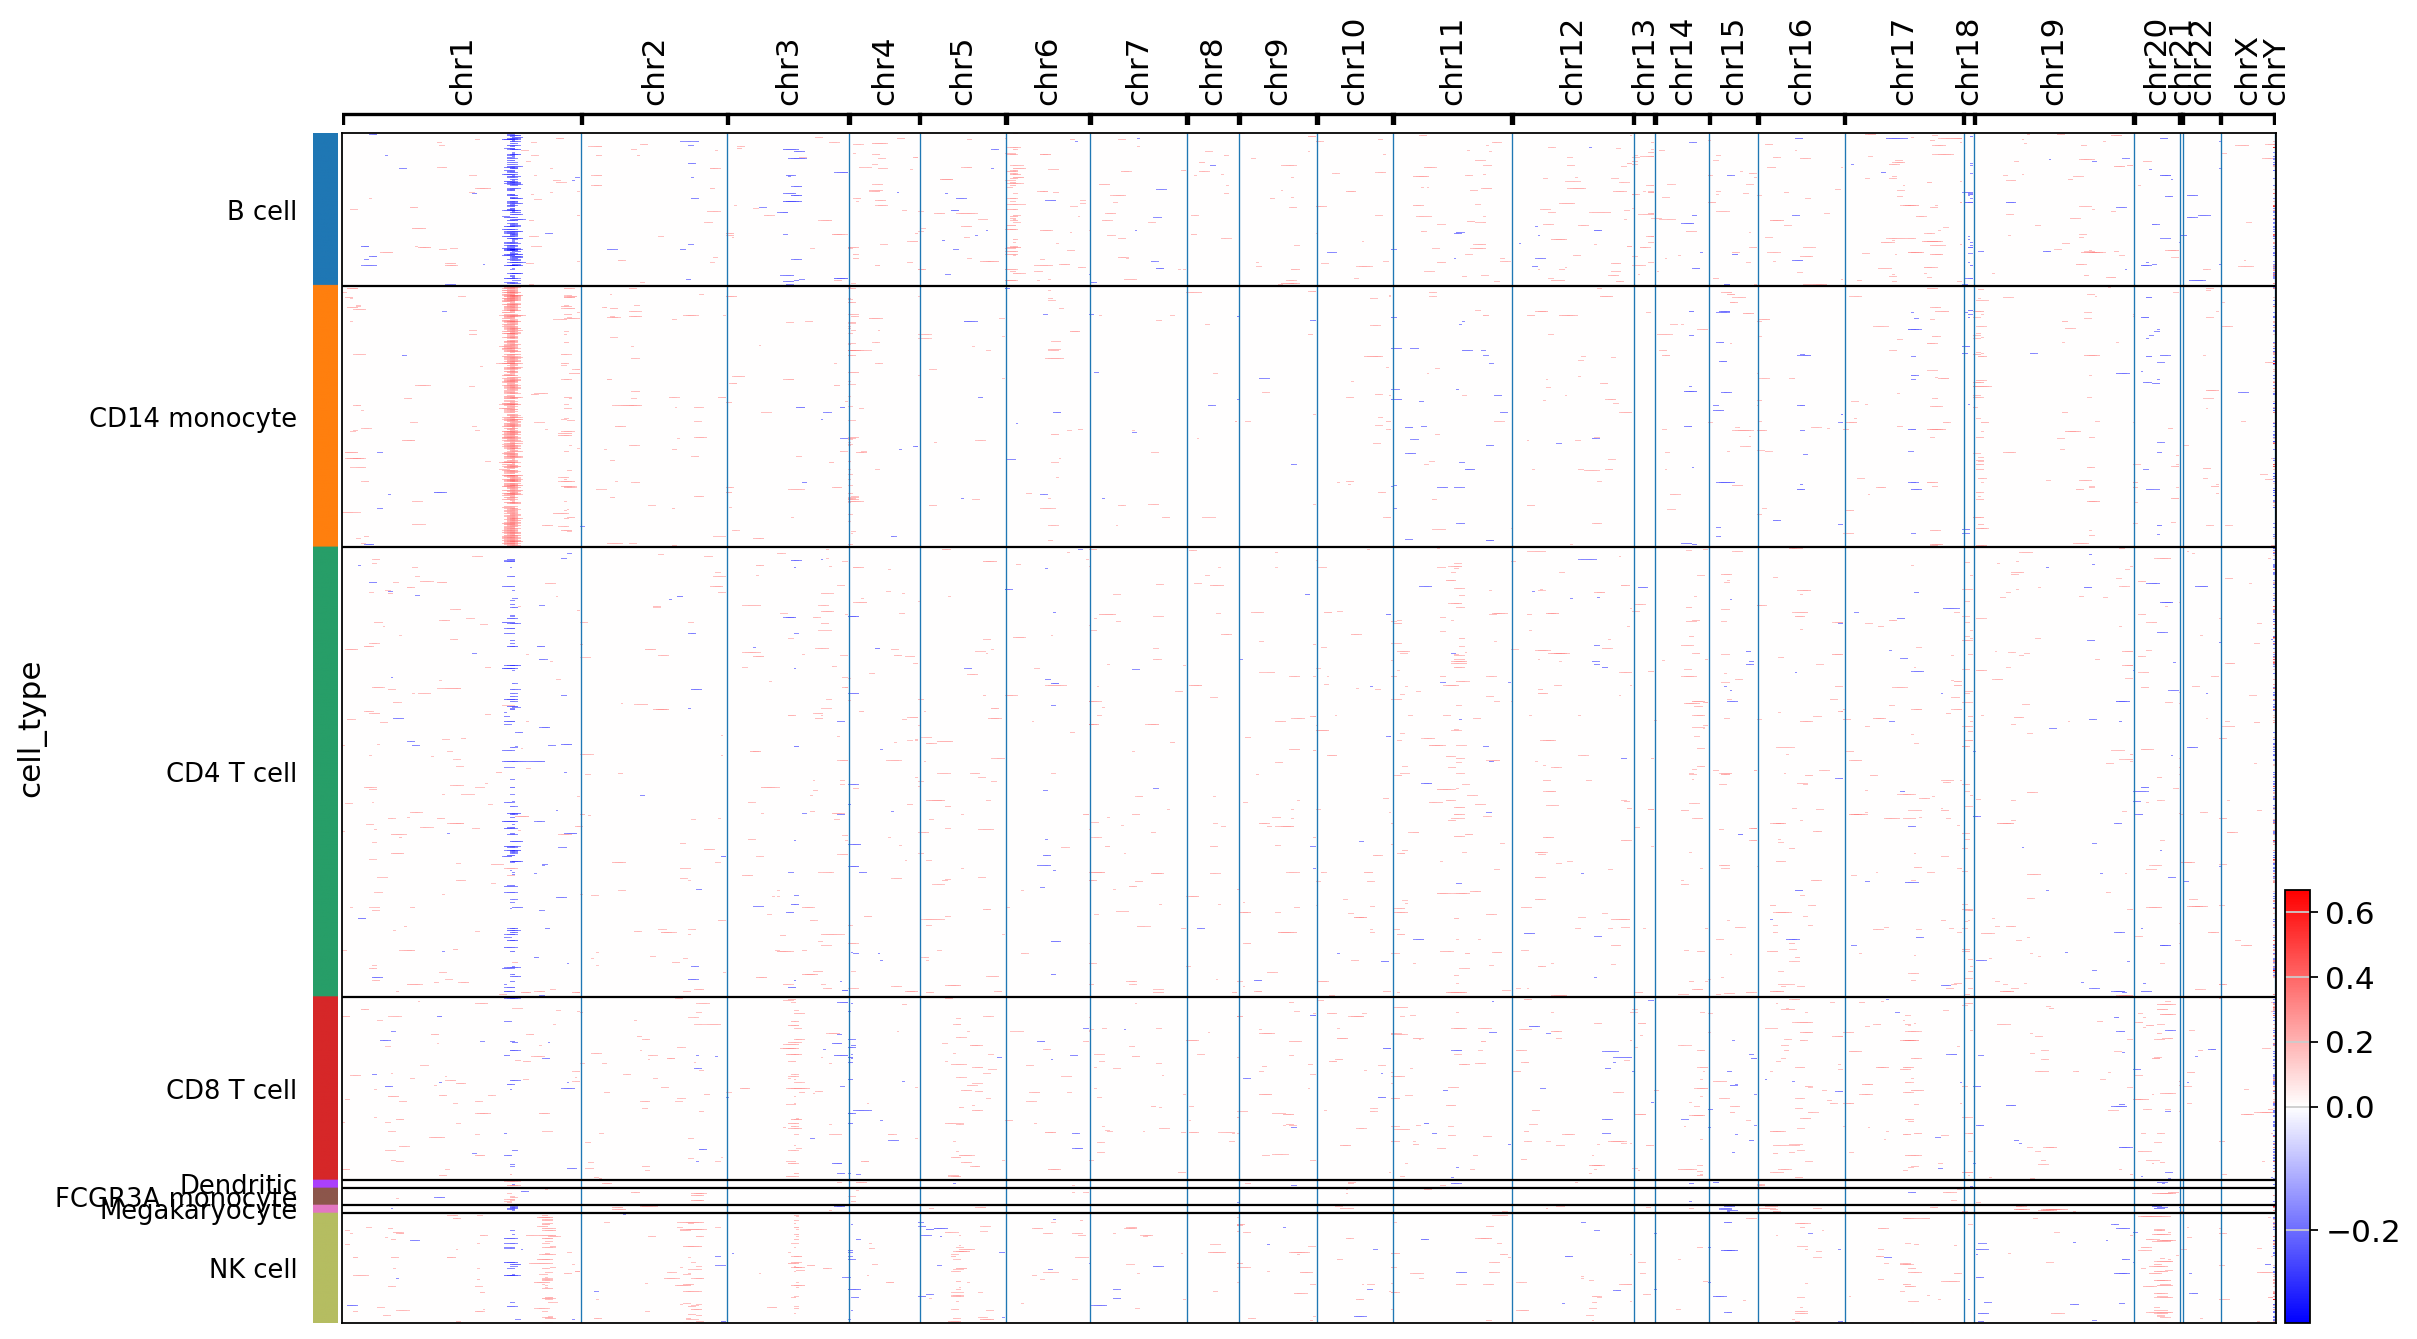

In [18]:
cnv.tl.infercnv(
    ad_filt4,
    reference_key = None,
    exclude_chromosomes=['nan'],
    window_size=100,
    dynamic_threshold=2.5,
    calculate_gene_values=True
)

# Visualize inferred CNVs as a heatmap, grouped by cell type
# This helps assess whether certain cell types have stronger or distinct CNA signatures
cnv.pl.chromosome_heatmap(ad_filt4, groupby="cell_type")

Performance Analysis was done the same as with the above benchmarking data

In [23]:
# annotate_cnv_regions(ad_filt4, threshold=.10)
# ad_filt4.obs["inferred_cnvs"].value_counts()
ad_filt4 = run_hmm_cnv_segmentation(
    ad_filt4,
    bin_size=100,
    n_states=3,
    use_layer="smoothed",
    obsm_key="hmm_cnv_states",
    min_cnv_length=3  # only call CNVs if they span ≥ 3 bins
)

# Generate a bin-by-bin simulated CNV label matrix (cells × bins) using parsed region strings from adata.obs['simulated_cnvs']
simulated_cnv_df = parse_simulated_cnvs(ad_filt4)

In [24]:
# Retrieve predicted CNV states (cells × bins) from HMM segmentation results
pred = ad_filt4.obsm["hmm_cnv_states"]

# Align the simulated CNV labels to the predicted CNV matrix by matching cell and bin indices
true = simulated_cnv_df.loc[pred.index, pred.columns]


In [35]:
# 1. Make sure both DataFrames have same cells and same bins
common_cells = pred.index.intersection(simulated_cnv_df.index)
common_bins = pred.columns.intersection(simulated_cnv_df.columns)

# 2. Subset and sort both matrices to align
pred_aligned = pred.loc[common_cells, common_bins].copy()
true_aligned = simulated_cnv_df.loc[common_cells, common_bins].copy()

# 3. Convert to NumPy arrays and flatten
y_pred = pred_aligned.values.flatten()
y_true = true_aligned.values.flatten()

# 4. Mask out any nan/nulls (if applicable)
mask = ~pd.isnull(y_pred) & ~pd.isnull(y_true)
y_pred = y_pred[mask]
y_true = y_true[mask]

# 5. Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=["gain", "neutral"]))

              precision    recall  f1-score   support

        gain       0.00      0.00      0.00         0
     neutral       1.00      0.52      0.68    239145

    accuracy                           0.52    239145
   macro avg       0.50      0.26      0.34    239145
weighted avg       1.00      0.52      0.68    239145



The segmentation and output from inferCNV was unable to detect CNV losses, thus only 2 labels, gain and neutral, were predicted.

In [36]:
print("Shape of prediction matrix:", pred.shape)
print("Shape of simulated label matrix:", simulated_cnv_df.shape)
print("Common cells:", len(common_cells))
print("Common bins:", len(common_bins))

Shape of prediction matrix: (2235, 107)
Shape of simulated label matrix: (2235, 107)
Common cells: 2235
Common bins: 95
